https://www.kaggle.com/shivamb/homecreditrisk-extensive-eda-baseline-0-772

In [1]:
from plotly.offline import init_notebook_mode, iplot
from wordcloud import WordCloud
import plotly.graph_objs as go
import multiprocessing as mp
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly import tools
from datetime import date
import pandas as pd
import numpy as np 
import seaborn as sns
import random 
from sklearn.metrics import log_loss, roc_auc_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from  tqdm import tqdm
import gc
from functools import partial
import warnings
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

path = "../input/"

pd.set_option("display.max_columns", 2000)

import time
from contextlib import contextmanager

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


In [2]:
with timer('read application_train.csv'):
    app_train = pd.read_csv(path + "application_train.csv")
    app_train.head()

read application_train.csv - done in 3s


In [3]:
with timer('read bureau.csv'):
    bureau = pd.read_csv(path + "bureau.csv")
    bureau.head()

read bureau.csv - done in 3s


In [4]:
with timer('read bureau_balance.csv'):
    bureau_balance = pd.read_csv(path + "bureau_balance.csv")
    bureau_balance.head()

read bureau_balance.csv - done in 5s


In [5]:
with timer('read credit_card_balance.csv'):
    credit_card_balance = pd.read_csv(path + "credit_card_balance.csv")
    credit_card_balance.head()

read credit_card_balance.csv - done in 8s


In [6]:
with timer('read POS_CASH_balance.csv'):
    pcb = pd.read_csv(path + "POS_CASH_balance.csv")
    pcb.head()

read POS_CASH_balance.csv - done in 6s


In [7]:
with timer('read previous_application.csv'):
    previous_application = pd.read_csv(path + "previous_application.csv")
    previous_application.head()

read previous_application.csv - done in 6s


In [8]:
with timer('read installments_payments.csv'):
    installments_payments = pd.read_csv(path + "installments_payments.csv")
    installments_payments.head()

read installments_payments.csv - done in 11s


## 学習データ準備

In [9]:
from sklearn.model_selection import train_test_split 
import lightgbm as lgb


with timer('read application_test.csv'):
    app_test = pd.read_csv('../input/application_test.csv')


with timer('clean'):    
    app_train['app NAN num'] = app_train.isnull().sum(axis = 1).values
    app_test['app NAN num'] = app_test.isnull().sum(axis = 1).values


with timer('perapare'):
    app_test['is_test'] = 1 
    app_test['is_train'] = 0
    app_train['is_test'] = 0
    app_train['is_train'] = 1

    # target variable
    Y = app_train['TARGET']
    train_X = app_train.drop(['TARGET'], axis = 1)

    # test ID
    test_id = app_test['SK_ID_CURR']
    test_X = app_test

    # merge train and test datasets for preprocessing
    data = pd.concat([train_X, test_X], axis=0)

read application_test.csv - done in 1s
clean - done in 1s
perapare - done in 1s


### <a id="0.1">0.1 Prepare - Data Cleaning</a>

In [10]:

with timer('app remove meaningless feature'):
    data.drop(['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 
            'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 
            'FLAG_DOCUMENT_21'], axis = 1, inplace = True)

with timer('replace outliers'):
    data['DAYS_EMPLOYED'].replace(365243, np.nan, inplace = True)
    data['CODE_GENDER'].replace('XNA', np.nan, inplace=True)
    data['NAME_FAMILY_STATUS'].replace('Unknown', np.nan, inplace=True)
    data['ORGANIZATION_TYPE'].replace('XNA', np.nan, inplace=True)
    data['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)

    data.loc[data['OWN_CAR_AGE'] > 80, 'OWN_CAR_AGE'] = np.nan
    data.loc[data['REGION_RATING_CLIENT_W_CITY'] < 0, 'REGION_RATING_CLIENT_W_CITY'] = np.nan
    data.loc[data['AMT_INCOME_TOTAL'] > 1e8, 'AMT_INCOME_TOTAL'] = np.nan
    data.loc[data['AMT_REQ_CREDIT_BUREAU_QRT'] > 10, 'AMT_REQ_CREDIT_BUREAU_QRT'] = np.nan
    data.loc[data['OBS_30_CNT_SOCIAL_CIRCLE'] > 40, 'OBS_30_CNT_SOCIAL_CIRCLE'] = np.nan


app remove meaningless feature - done in 0s
replace outliers - done in 0s


In [11]:
with timer('handcraft definition'):
    data['app self cate OCCUPATION_TYPE'] = data['OCCUPATION_TYPE'].replace(
                       {'High skill tech staff':'High_Skill',
                        'Managers':0,
                        'Accountants':0,
                        'HR staff':0,
                        'Core staff':0,
                       'Cooking staff':1,
                        'Realty agents':0,
                        'Sales staff':1,
                        'IT staff':0,
                        'Medicine staff':0,
                        'Secretaries':0,
                        'Security staff':1,
                        'Cleaning staff':1,
                          'Laborers':1,
                          'Low-skill Laborers':1,
                          'Cleaning staff':1,
                        'Waiters/barmen staff':1,
                        'Private service staff':0,
                        'Drivers':1,
                        'High skill tech staff':0                                                                       
                        },inplace=False)

    data['app self cate NAME_INCOME_TYPE'] = data['NAME_INCOME_TYPE'].replace(
                        {'Businessman':0,
                         'Student':0,
                         'Unemployed':1,
                         'Working':1,
                         'Commercial associate':0,                        
                         'State servant':0,
                         'Pensioner':0,                         
                         'Maternity leave':1}
                        ,inplace=False)

    data['app self cate NAME_HOUSING_TYPE'] = data['NAME_HOUSING_TYPE'].replace(
                        {'Rented apartment':1,
                         'With parents':1,
                         'Municipal apartment':0,
                         'Co-op apartment':0,
                         'House / apartment':0,                        
                         'Office apartment':0}
                        ,inplace=False)

    data['app self cate ORGANIZATION_TYPE'] = data['ORGANIZATION_TYPE'].replace(
                        {'Transport':1, 
                        'Industry: type 13':1, 
                        'Industry: type 8':1, 
                        'Restaurant':1, 
                        'Construction':1,
                        'Cleaning':1,
                        'Industry: type 1':1,
                        'Industry: type 3':1,
                        'Realtor':1,
                        'Agriculture':1,
                        'Trade: type 3':1,
                        'Self-employed':1,
                        'Industry: type 4':1,
                        'Security':0,
                        'Trade: type 7':0,
                        'Business Entity Type 3':0,
                        'Transport: type 4':0,
                        'Mobile':0,
                        'Trade: type 1':0,
                        'Industry: type 11':0,
                        'Business Entity Type 2':0,
                        'Postal':0,
                        'Advertising':0,
                        'Business Entity Type 1':0,
                        'Industry: type 7':0,
                        'Housing':0,
                        'Legal Services':0,
                        'Transport: type 2':0,
                        'Other':0,
                        'Telecom':0,
                        'Industry: type 2':0,
                        'Industry: type 6':0,
                        'Emergency':0,
                        'Kindergarten':0,
                        'Trade: type 2':0,
                        'Government':0,
                        'Industry: type 5':0,
                        'Industry: type 9':0,
                        'Electricity':0,
                        'Services':0,
                        'Medicine':0,
                        'Industry: type 10':0,
                        'Hotel':0,
                        'Trade: type 5':0,
                        'School':0,
                        'Religion':0,
                        'Insurance':0,
                        'Culture':0,
                        'XNA':0,
                        'Bank':0,
                        'Military':0,
                        'Police':0,
                        'University':0,
                        'Security Ministries':0,
                        'Trade: type 6':0,
                        'Transport: type 1':0,
                        'Industry: type 12':0,
                        'Trade: type 4':0}
                        ,inplace=False)

handcraft definition - done in 1s


In [12]:
with timer('bureau replace outliers'):
    bureau['AMT_CREDIT_SUM'].fillna(0, inplace=True)
    bureau['AMT_CREDIT_SUM_DEBT'].fillna(0, inplace=True)
    bureau['AMT_CREDIT_SUM_OVERDUE'].fillna(0, inplace=True)
    bureau['CNT_CREDIT_PROLONG'].fillna(0, inplace=True)

    bureau['DAYS_CREDIT_ENDDATE'][bureau['DAYS_CREDIT_ENDDATE'] < -40000] = np.nan
    bureau['DAYS_CREDIT_UPDATE'][bureau['DAYS_CREDIT_UPDATE'] < -40000] = np.nan
    bureau['DAYS_ENDDATE_FACT'][bureau['DAYS_ENDDATE_FACT'] < -40000] = np.nan

bureau replace outliers - done in 0s


In [13]:
with timer('previous_application replace outliers'):
    previous_application['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    previous_application['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    previous_application['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    previous_application['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    previous_application['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)
      

previous_application replace outliers - done in 0s


In [14]:
with timer('credit_card_balance replace outliers'):
    credit_card_balance['AMT_DRAWINGS_ATM_CURRENT'][credit_card_balance['AMT_DRAWINGS_ATM_CURRENT'] < 0] = np.nan
    credit_card_balance['AMT_DRAWINGS_CURRENT'][credit_card_balance['AMT_DRAWINGS_CURRENT'] < 0] = np.nan

credit_card_balance replace outliers - done in 0s


In [15]:
with timer('app groupby features define'):
    AGGREGATION_RECIPIES = [
        (['CODE_GENDER', 'NAME_EDUCATION_TYPE'], [('AMT_ANNUITY', 'max'),
                                                  ('AMT_CREDIT', 'max'),
                                                  ('EXT_SOURCE_1', 'mean'),
                                                  ('EXT_SOURCE_2', 'mean'),
                                                  ('OWN_CAR_AGE', 'max'),
                                                  ('OWN_CAR_AGE', 'sum')]),
        (['CODE_GENDER', 'ORGANIZATION_TYPE'], [('AMT_ANNUITY', 'mean'),
                                                ('AMT_INCOME_TOTAL', 'mean'),
                                                ('DAYS_REGISTRATION', 'mean'),
                                                ('EXT_SOURCE_1', 'mean')]),
        (['CODE_GENDER', 'REG_CITY_NOT_WORK_CITY'], [('AMT_ANNUITY', 'mean'),
                                                     ('CNT_CHILDREN', 'mean'),
                                                     ('DAYS_ID_PUBLISH', 'mean')]),
        (['CODE_GENDER', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'REG_CITY_NOT_WORK_CITY'], [('EXT_SOURCE_1', 'mean'),
                                                                                               ('EXT_SOURCE_2', 'mean')]),
        (['NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE'], [('AMT_CREDIT', 'mean'),
                                                      ('AMT_REQ_CREDIT_BUREAU_YEAR', 'mean'),
                                                      ('APARTMENTS_AVG', 'mean'),
                                                      ('BASEMENTAREA_AVG', 'mean'),
                                                      ('EXT_SOURCE_1', 'mean'),
                                                      ('EXT_SOURCE_2', 'mean'),
                                                      ('EXT_SOURCE_3', 'mean'),
                                                      ('NONLIVINGAREA_AVG', 'mean'),
                                                      ('OWN_CAR_AGE', 'mean'),
                                                      ('YEARS_BUILD_AVG', 'mean')]),
        (['NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'REG_CITY_NOT_WORK_CITY'], [('ELEVATORS_AVG', 'mean'),
                                                                                ('EXT_SOURCE_1', 'mean')]),
        (['OCCUPATION_TYPE'], [('AMT_ANNUITY', 'mean'),
                               ('CNT_CHILDREN', 'mean'),
                               ('CNT_FAM_MEMBERS', 'mean'),
                               ('DAYS_BIRTH', 'mean'),
                               ('DAYS_EMPLOYED', 'mean'),
                               ('DAYS_ID_PUBLISH', 'mean'),
                               ('DAYS_REGISTRATION', 'mean'),
                               ('EXT_SOURCE_1', 'mean'),
                               ('EXT_SOURCE_2', 'mean'),
                               ('EXT_SOURCE_3', 'mean')]),
    ]

app groupby features define - done in 0s


In [16]:
with timer('app groupby features'):
    groupby_aggregate_names = []
    for groupby_cols, specs in tqdm(AGGREGATION_RECIPIES):
        group_object = data.groupby(groupby_cols)
        for select, agg in tqdm(specs):
            groupby_aggregate_name = 'app {}_{}_{}'.format('_'.join(groupby_cols), agg, select)
            data = data.merge(group_object[select]
                                  .agg(agg)
                                  .reset_index()
                                  .rename(index=str,
                                          columns={select: groupby_aggregate_name})
                                  [groupby_cols + [groupby_aggregate_name]],
                                  on=groupby_cols,
                                  how='left')
            groupby_aggregate_names.append(groupby_aggregate_name)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:27<00:00,  3.95s/it]


app groupby features - done in 28s


In [17]:
with timer('app groupby features diff'):
    diff_feature_names = []
    for groupby_cols, specs in tqdm(AGGREGATION_RECIPIES):
        for select, agg in tqdm(specs):
            if agg in ['mean','median','max','min']:
                groupby_aggregate_name = 'app {}_{}_{}'.format('_'.join(groupby_cols), agg, select)
                diff_name = '{}_diff'.format(groupby_aggregate_name)
                abs_diff_name = '{}_abs_diff'.format(groupby_aggregate_name)

                data[diff_name] = data[select] - data[groupby_aggregate_name] 
                data[abs_diff_name] = np.abs(data[select] - data[groupby_aggregate_name])

                diff_feature_names.append(diff_name)
                diff_feature_names.append(abs_diff_name)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.96it/s]


app groupby features diff - done in 1s


### <a id="0.2">0.2 Prepare - Categorical Data Processing</a>

In [18]:
with timer('categorical data processing'):
    # function to obtain Categorical Features
    def _get_categorical_features(df):
        feats = [col for col in list(df.columns) if df[col].dtype == 'object']
        return feats

    # function to factorize categorical features
    def _factorize_categoricals(df, cats):
        for col in cats:
            df[col], _ = pd.factorize(df[col])
        return df 

    # function to create dummy variables of categorical features
    def _get_dummies(df, cats):
        for col in cats:
            df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
        return df 

    # get categorical features
    data_cats = _get_categorical_features(data)
    prev_app_cats = _get_categorical_features(previous_application)
    bureau_cats = _get_categorical_features(bureau)
    pcb_cats = _get_categorical_features(pcb)
    ccbal_cats = _get_categorical_features(credit_card_balance)

    # create additional dummy features - 
    previous_application = _get_dummies(previous_application, prev_app_cats)
    bureau = _get_dummies(bureau, bureau_cats)
    pcb = _get_dummies(pcb, pcb_cats)
    credit_card_balance = _get_dummies(credit_card_balance, ccbal_cats)

    # factorize the categorical features from train and test data
    data = _factorize_categoricals(data, data_cats)

categorical data processing - done in 20s


## feature engineering

### <a id="1.1">1.1 Feature Engineering - Previous Applications</a>

In [19]:
with timer('previous_application features'):
    ## count the number of previous applications for a given ID
    prev_apps_count = previous_application[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    previous_application['pre SK_ID_PREV_CNT'] = previous_application['SK_ID_CURR'].map(prev_apps_count['SK_ID_PREV'])
    previous_application.drop(['SK_ID_PREV'], axis = 1, inplace = True)

    # nan num
    previous_application['pre NAN num'] = previous_application.isnull().sum(axis = 1).values

    # Add feature: value ask / value received percentage
    previous_application['pre AMT_APPLICATION / AMT_CREDIT'] = previous_application['AMT_APPLICATION'] / previous_application['AMT_CREDIT']
    previous_application['pre loan AMT_APPLICATION / AMT_CREDIT'] = previous_application['NAME_CONTRACT_TYPE_Cash loans'] * previous_application['AMT_APPLICATION'] / previous_application['AMT_CREDIT']
    previous_application['pre revo AMT_APPLICATION / AMT_CREDIT'] = previous_application['NAME_CONTRACT_TYPE_Revolving loans'] * previous_application['AMT_APPLICATION'] / previous_application['AMT_CREDIT']
    previous_application['pre loan AMT_CREDIT / AMT_ANNUITY'] = previous_application['NAME_CONTRACT_TYPE_Cash loans'] * previous_application['AMT_CREDIT'] / previous_application['AMT_ANNUITY']
    previous_application['pre con loan AMT_CREDIT / AMT_ANNUITY'] = previous_application['NAME_CONTRACT_TYPE_Consumer loans'] * previous_application['AMT_CREDIT'] / previous_application['AMT_ANNUITY']
    previous_application['pre revo AMT_CREDIT / AMT_ANNUITY'] = previous_application['NAME_CONTRACT_TYPE_Revolving loans'] * previous_application['AMT_CREDIT'] / previous_application['AMT_ANNUITY']

    
with timer('previous_application features mean'):
    ## Average values for all other features in previous applications
    prev_apps_avg = previous_application.groupby('SK_ID_CURR').mean()
    prev_apps_avg.columns = ['pre ' + col + '_mean' for col in prev_apps_avg.columns]
    data = data.merge(right=prev_apps_avg.reset_index(), how='left', on='SK_ID_CURR')
    del prev_apps_avg
    gc.collect()

with timer('previous_application features agg by self choice'):
    num_aggregations = {
            'AMT_ANNUITY': ['min', 'max', 'mean', 'var'],
            'AMT_APPLICATION': ['min', 'max', 'mean', 'var'],
            'AMT_CREDIT': ['min', 'max', 'mean', 'var'],
            'pre AMT_APPLICATION / AMT_CREDIT': ['min', 'max', 'mean', 'var'],
            'pre loan AMT_APPLICATION / AMT_CREDIT': ['min', 'max', 'mean', 'var'],        
            'AMT_DOWN_PAYMENT': ['min', 'max', 'mean', 'var'],
            'AMT_GOODS_PRICE': ['min', 'max', 'mean', 'var'],
            'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean', 'var'],
            'RATE_DOWN_PAYMENT': ['min', 'max', 'mean', 'var'],
            'DAYS_DECISION': ['min', 'max', 'mean', 'var'],
            'CNT_PAYMENT': ['min', 'max', 'mean', 'var'],
    }

    cat_aggregations = {}

    prev_agg = previous_application.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['pre ' + e[0] for e in prev_agg.columns.tolist()])

with timer('previous_application features domain agg'):
    # Approved Applications
    approved = previous_application[previous_application['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['pre APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')

    # Refused Applications
    refused = previous_application[previous_application['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['pre REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_done = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg
    gc.collect()

    data = data.merge(right=prev_done.reset_index(), how='left', on='SK_ID_CURR')

previous_application features - done in 7s
previous_application features mean - done in 12s
previous_application features agg by self choice - done in 3s
previous_application features domain agg - done in 6s


### <a id="1.2">1.2 Feature Engineering - Bureau Data</a>

In [20]:
with timer('bureau features'):

    bureau['bur NAN num'] = bureau.isnull().sum(axis = 1).values
    bureau_balance['bur_bal NAN num'] = bureau_balance.isnull().sum(axis = 1).values


with timer('bureau features mean'):
    # Average Values for all bureau features 
    bureau_avg = bureau.groupby('SK_ID_CURR').mean()
    bureau_avg['bur CNT'] = bureau[['SK_ID_BUREAU','SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_BUREAU']
    bureau_avg.columns = ['bur ' + f_ + '_mean' for f_ in bureau_avg.columns]
    data = data.merge(right=bureau_avg.reset_index(), how='left', on='SK_ID_CURR')
    del bureau_avg
    gc.collect()

with timer('bureau features agg by self choice'):
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size', 'var']}
    bb_agg = bureau_balance.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bureau_balance, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean', 'max'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean', 'max'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean', 'max'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum', 'max', 'min'],
        'AMT_ANNUITY': ['mean', 'sum', 'max', 'min'],
        'CNT_CREDIT_PROLONG': ['mean', 'sum', 'max', 'min'],
        'MONTHS_BALANCE_MIN': ['mean', 'sum', 'max', 'min'],
        'MONTHS_BALANCE_MAX': ['mean', 'sum', 'max', 'min'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum', 'max', 'min']
    }

    # Bureau and bureau_balance categorical features
    cat_aggregations = {}

    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['bur_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
with timer('bureau features domain agg'):
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['bur_ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()

    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['bur_CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()

    data = data.merge(right=bureau_agg.reset_index(), how='left', on='SK_ID_CURR')

bureau features - done in 4s
bureau features mean - done in 11s
bureau features agg by self choice - done in 6s
bureau features domain agg - done in 15s


### <a id="1.3">1.3 Feature Engineering - Previous Installments</a>

In [21]:
with timer('installments_payments features'):
    # nan num
    installments_payments['ins NAN num'] = installments_payments.isnull().sum(axis = 1).values

    # Percentage and difference paid in each installment (amount paid and installment value)
    installments_payments['ins AMT_PAYMENT / AMT_INSTALMENT'] = installments_payments['AMT_PAYMENT'] / installments_payments['AMT_INSTALMENT']
    installments_payments['ins AMT_INSTALMENT - AMT_PAYMENT'] = installments_payments['AMT_INSTALMENT'] - installments_payments['AMT_PAYMENT']

    # Days past due and days before due (no negative values)
    installments_payments['ins DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT'] = installments_payments['DAYS_ENTRY_PAYMENT'] - installments_payments['DAYS_INSTALMENT']
    installments_payments['ins DAYS_INSTALMENT - DAYS_ENTRY_PAYMENT'] = installments_payments['DAYS_INSTALMENT'] - installments_payments['DAYS_ENTRY_PAYMENT']
    installments_payments['ins DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT'] = installments_payments['ins DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT'].apply(lambda x: x if x > 0 else 0)
    installments_payments['ins DAYS_INSTALMENT - DAYS_ENTRY_PAYMENT'] = installments_payments['ins DAYS_INSTALMENT - DAYS_ENTRY_PAYMENT'].apply(lambda x: x if x > 0 else 0)

    #
    installments_payments['ins instalment_paid_late'] = (installments_payments['ins DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT'] > 0).astype(int)
    installments_payments['ins instalment_paid_over'] = (installments_payments['ins AMT_INSTALMENT - AMT_PAYMENT'] > 0).astype(int)

with timer('installments_payments features mean'):   
    ## Average values for all other variables in installments payments
    avg_inst = installments_payments.groupby('SK_ID_CURR').mean()
    avg_inst.columns = ['ins ' + f_ + '_mean' for f_ in avg_inst.columns]
    data = data.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')
    del avg_inst
    gc.collect()

    ## count the number of previous installments
    cnt_inst = installments_payments[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    installments_payments['ins_SK_ID_PREV_CNT'] = installments_payments['SK_ID_CURR'].map(cnt_inst['SK_ID_PREV'])
    installments_payments.drop(['SK_ID_PREV'], axis = 1, inplace = True)

with timer('installments_payments features agg by self choice'):
    aggregations = {
         'NUM_INSTALMENT_VERSION': ['nunique'],
         'ins DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT': ['max', 'sum','min','std','var'],
         'ins DAYS_INSTALMENT - DAYS_ENTRY_PAYMENT': ['max', 'sum','min','std','var'],
         'ins AMT_PAYMENT / AMT_INSTALMENT': [ 'max', 'min','std','var'],
         'ins AMT_INSTALMENT - AMT_PAYMENT': [ 'max', 'min','std','var'],
         'AMT_INSTALMENT': ['max', 'sum','min','std','var'],
         'AMT_PAYMENT': ['min', 'max', 'sum','std','var'],
         'DAYS_ENTRY_PAYMENT': ['max', 'sum','std','var'],
         'ins instalment_paid_late': ['sum','mean','max','min','std'],   
         'ins instalment_paid_over': ['sum','mean','max','min','std'],
    }

    ins_agg = installments_payments.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['ins ' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])

    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = installments_payments.groupby('SK_ID_CURR').size()
    #del installments_payments
    gc.collect()

    data = data.merge(right=ins_agg.reset_index(), how='left', on='SK_ID_CURR')

#with timer('installments_payments features domain agg'):

installments_payments features - done in 9s
installments_payments features mean - done in 19s
installments_payments features agg by self choice - done in 26s


In [22]:
def last_k_installment_features(ins, periods):   
    features = {}

    for period in periods:
        period_name = 'last_{}_'.format(period)
        gr_period = ins[(ins['DAYS_INSTALMENT'] < period)].groupby(['SK_ID_CURR'])
        
        features = add_features_in_group(features,gr_period, 'NUM_INSTALMENT_VERSION', 
                                       ['sum','mean','max','min','std', 'median'],
                                         'last_{}_'.format(period))
        
        features = add_features_in_group(features,gr_period, 'ins DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT', 
                                       ['sum','mean','max','min','std', 'median'],
                                         'last_{}_'.format(period))
        features = add_features_in_group(features,gr_period ,'ins instalment_paid_late', 
                                     ['count','mean'],
                                         'last_{}_'.format(period))
        features = add_features_in_group(features,gr_period ,'ins AMT_INSTALMENT - AMT_PAYMENT', 
                                       ['sum','mean','max','min','std', 'median'],
                                         'last_{}_'.format(period))
        features = add_features_in_group(features,gr_period,'ins instalment_paid_over', 
                                     ['count','mean'],
                                         'last_{}_'.format(period))        
    
    pd_features = pd.DataFrame(features)
    pd_features.index.name = 'SK_ID_CURR'
        
    return pd_features
  
def add_features_in_group(features, gr_, feature_name, aggs, prefix):
    for agg in aggs:
        if agg == 'sum':
            features['{}{}_sum'.format(prefix, feature_name)] = gr_[feature_name].sum()
        elif agg == 'mean':
            features['{}{}_mean'.format(prefix, feature_name)] = gr_[feature_name].mean()
        elif agg == 'max':
            features['{}{}_max'.format(prefix, feature_name)] = gr_[feature_name].max()
        elif agg == 'min':
            features['{}{}_min'.format(prefix, feature_name)] = gr_[feature_name].min()
        elif agg == 'std':
            features['{}{}_std'.format(prefix, feature_name)] = gr_[feature_name].std()
        elif agg == 'count':
            features['{}{}_count'.format(prefix, feature_name)] = gr_[feature_name].count()
        elif agg == 'skew':
            features['{}{}_skew'.format(prefix, feature_name)] = skew(gr_[feature_name])
        elif agg == 'kurt':
            features['{}{}_kurt'.format(prefix, feature_name)] = kurtosis(gr_[feature_name])
        elif agg == 'iqr':
            features['{}{}_iqr'.format(prefix, feature_name)] = iqr(gr_[feature_name])
        elif agg == 'median':
            features['{}{}_median'.format(prefix, feature_name)] = gr_[feature_name].median()
    return features



In [23]:
with timer('installments_payments features period'):
    g = last_k_installment_features(installments_payments, periods=[1,5,10,20,50,100])
    data = data.merge(g, on='SK_ID_CURR', how='left')

installments_payments features period - done in 49s


### <a id="1.4">1.4 Feature Engineering - Pos Cash Balance</a>

In [24]:
with timer('pcb features'):
    pcb['pcb NAN num'] = pcb.isnull().sum(axis = 1).values
    pcb['pcb cash_paid_late'] = (pcb['SK_DPD'] > 0).astype(int)
    pcb['pcb cash_paid_late_with_tolerance'] = (pcb['SK_DPD_DEF'] > 0).astype(int)

    ### count the number of pos cash for a given ID
    pcb_count = pcb[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    pcb['pcb_SK_ID_PREV_CNT'] = pcb['SK_ID_CURR'].map(pcb_count['SK_ID_PREV'])
    
with timer('pcb features mean'):
    ## Average Values for all other variables in pos cash
    pcb_avg = pcb.groupby('SK_ID_CURR').mean()
    data = data.merge(right=pcb_avg.reset_index(), how='left', on='SK_ID_CURR')
    del pcb_avg
    gc.collect()

with timer('pcb features agg by self choice'):
    pos_cash_sorted = pcb.sort_values(['SK_ID_CURR', 'MONTHS_BALANCE'])
    group_object = pos_cash_sorted.groupby('SK_ID_CURR')['CNT_INSTALMENT_FUTURE'].last().reset_index()
    group_object.rename(index=str, columns={'CNT_INSTALMENT_FUTURE': 'pcb cash_remaining_installments'}, inplace=True)
    data = data.merge(group_object, on=['SK_ID_CURR'], how='left')

with timer('pcb features domain agg'):
    pcb['is_contract_status_completed'] = pcb['NAME_CONTRACT_STATUS'] == 'Completed'
    group_object = pcb.groupby(['SK_ID_CURR'])['is_contract_status_completed'].sum().reset_index()
    group_object.rename(index=str,
                        columns={'is_contract_status_completed': 'pcb cash_completed_contracts'},
                        inplace=True)
    data = data.merge(group_object, on=['SK_ID_CURR'], how='left')


pcb features - done in 5s
pcb features mean - done in 21s
pcb features agg by self choice - done in 24s
pcb features domain agg - done in 17s


In [25]:
def last_k_pcb_features(dt, periods):
    
    features = {}
    for period in periods:
        period_name = 'last_{}_'.format(period)
        gr_period = pcb[(pcb['MONTHS_BALANCE'] < period)].groupby(['SK_ID_CURR'])
            
        features = add_features_in_group(features, gr_period, 'pcb cash_paid_late',
                                             ['count', 'mean'],
                                             period_name)
        features = add_features_in_group(features, gr_period, 'pcb cash_paid_late_with_tolerance',
                                             ['count', 'mean'],
                                             period_name)
        features = add_features_in_group(features, gr_period, 'SK_DPD',
                                             ['sum', 'mean', 'max', 'min', 'median'],
                                             period_name)
        features = add_features_in_group(features, gr_period, 'SK_DPD_DEF',
                                             ['sum', 'mean', 'max', 'min','median'],
                                             period_name)

    pd_features = pd.DataFrame(features)
    pd_features.index.name = 'SK_ID_CURR'
    return pd_features


def add_features_in_group(features, gr_, feature_name, aggs, prefix):
    for agg in aggs:
        if agg == 'sum':
            features['{}{}_sum'.format(prefix, feature_name)] = gr_[feature_name].sum()
        elif agg == 'mean':
            features['{}{}_mean'.format(prefix, feature_name)] = gr_[feature_name].mean()
        elif agg == 'max':
            features['{}{}_max'.format(prefix, feature_name)] = gr_[feature_name].max()
        elif agg == 'min':
            features['{}{}_min'.format(prefix, feature_name)] = gr_[feature_name].min()
        elif agg == 'std':
            features['{}{}_std'.format(prefix, feature_name)] = gr_[feature_name].std()
        elif agg == 'count':
            features['{}{}_count'.format(prefix, feature_name)] = gr_[feature_name].count()
        elif agg == 'skew':
            features['{}{}_skew'.format(prefix, feature_name)] = skew(gr_[feature_name])
        elif agg == 'kurt':
            features['{}{}_kurt'.format(prefix, feature_name)] = kurtosis(gr_[feature_name])
        elif agg == 'iqr':
            features['{}{}_iqr'.format(prefix, feature_name)] = iqr(gr_[feature_name])
        elif agg == 'median':
            features['{}{}_median'.format(prefix, feature_name)] = gr_[feature_name].median()
    return features


def last_loan_features(gr):
    gr_ = gr.copy()
    gr_.sort_values(['MONTHS_BALANCE'], ascending=False, inplace=True)
    last_installment_id = gr_['SK_ID_PREV'].iloc[0]
    gr_ = gr_[gr_['SK_ID_PREV'] == last_installment_id]  
    gr_ = gr_.groupby(['SK_ID_CURR'])
        
    features={}
    features = add_features_in_group(features, gr_, 'pcb cash_paid_late',
                                         ['count', 'sum', 'mean'],
                                         'last_loan_')
    features = add_features_in_group(features, gr_, 'pcb cash_paid_late_with_tolerance',
                                         ['sum', 'mean'],
                                         'last_loan_')
    features = add_features_in_group(features, gr_, 'SK_DPD',
                                         ['sum', 'mean', 'max', 'min', 'std'],
                                         'last_loan_')
    features = add_features_in_group(features, gr_, 'SK_DPD_DEF',
                                         ['sum', 'mean', 'max', 'min', 'std'],
                                         'last_loan_')
    pd_features = pd.DataFrame(features)
    pd_features.index.name = 'SK_ID_CURR'   
    
    return pd_features

In [26]:
with timer('pcb features period'):
    features = pd.DataFrame({'SK_ID_CURR': pcb['SK_ID_CURR'].unique()})
    g = last_k_pcb_features(pcb, periods=[-1, -6, -10, -30, -60])
    features = features.merge(g, on='SK_ID_CURR', how='left')
    data = data.merge(features, on='SK_ID_CURR', how='left')
    
with timer('pcb last_loan_features'):    
    g = last_loan_features(pcb)
    data = data.merge(g, on='SK_ID_CURR', how='left')



pcb features period - done in 33s
pcb last_loan_features - done in 20s


In [27]:
with timer('pcb features agg by self choice'):
    ### count the number of pos cash for a given ID
    pcb_count = pcb[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    pcb['pcb_SK_ID_PREV_CNT'] = pcb['SK_ID_CURR'].map(pcb_count['SK_ID_PREV'])
    pcb.drop(['SK_ID_PREV'], axis = 1, inplace = True)

    # Features
    aggregations = {
         'MONTHS_BALANCE': ['mean', 'max', 'min', 'sum', 'var', 'size'],
         'CNT_INSTALMENT' : ['mean', 'max'],
         'CNT_INSTALMENT_FUTURE' : ['mean', 'max'],
         'SK_DPD': ['mean', 'max', 'min', 'sum', 'var'],
         'SK_DPD_DEF': ['mean', 'max', 'min', 'sum', 'var']
    }
    pos_agg = pcb.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['pcb ' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])

    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pcb.groupby('SK_ID_CURR').size()
    del pcb
    gc.collect()

    data = data.merge(right=pos_agg.reset_index(), how='left', on='SK_ID_CURR')

pcb features agg by self choice - done in 26s


### <a id="1.5">1.5 Feature Engineering - Credit Card Balance </a>

In [28]:
with timer('credit_card_balance features handcraft'):
    # No of Loans per customer 
    grp = credit_card_balance.groupby(by = ['SK_ID_CURR'])['SK_ID_PREV'].nunique().reset_index().rename(index = str, columns = {'SK_ID_PREV': 'cre NO_LOANS'})
    credit_card_balance = credit_card_balance.merge(grp, on = ['SK_ID_CURR'], how = 'left')
    del grp 
    gc.collect()

    # No of Installments paid per Loan per Customer 
    grp = credit_card_balance.groupby(by = ['SK_ID_CURR', 'SK_ID_PREV'])['CNT_INSTALMENT_MATURE_CUM'].max().reset_index().rename(index = str, columns = {'CNT_INSTALMENT_MATURE_CUM': 'cre NO_INSTALMENTS'})
    grp1 = grp.groupby(by = ['SK_ID_CURR'])['cre NO_INSTALMENTS'].sum().reset_index().rename(index = str, columns = {'cre NO_INSTALMENTS': 'cre TOTAL_INSTALMENTS'})
    credit_card_balance = credit_card_balance.merge(grp1, on = ['SK_ID_CURR'], how = 'left')
    del grp, grp1
    gc.collect()

    # Average Number of installments paid per loan 
    credit_card_balance['cre INSTALLMENTS_PER_LOAN'] = (credit_card_balance['cre TOTAL_INSTALMENTS']/credit_card_balance['cre NO_LOANS']).astype('uint32')
    del credit_card_balance['cre TOTAL_INSTALMENTS']
    del credit_card_balance['cre NO_LOANS']
    gc.collect()


    

credit_card_balance features handcraft - done in 7s


In [29]:
with timer('credit_card_balance features handcraft'):
    credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL1'] = credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL']

    def f(x1, x2):

        balance = x1.max()
        limit = x2.max()

        return (balance/limit)

    # Calculate the ratio of Amount Balance to Credit Limit - CREDIT LOAD OF CUSTOMER 
    # This is done for each Credit limit value per loan per Customer 

    grp = credit_card_balance.groupby(by = ['SK_ID_CURR', 'SK_ID_PREV', 'AMT_CREDIT_LIMIT_ACTUAL']).apply(lambda x: f(x.AMT_BALANCE, x.AMT_CREDIT_LIMIT_ACTUAL1)).reset_index().rename(index = str, columns = {0: 'CREDIT_LOAD1'})
    del credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL1']
    gc.collect()

    # We now calculate the mean Credit load of All Loan transactions of Customer 
    grp1 = grp.groupby(by = ['SK_ID_CURR'])['CREDIT_LOAD1'].mean().reset_index().rename(index = str, columns = {'CREDIT_LOAD1': 'cre CREDIT_LOAD'})
    print(grp1.dtypes)

    credit_card_balance = credit_card_balance.merge(grp1, on = ['SK_ID_CURR'], how = 'left')
    del grp, grp1
    gc.collect()


SK_ID_CURR           int64
cre CREDIT_LOAD    float64
dtype: object
credit_card_balance features handcraft - done in 32s


In [30]:
with timer('credit_card_balance features handcraft'):
    def f(DPD):

        # DPD is a series of values of SK_DPD for each of the groupby combination 
        # We convert it to a list to get the number of SK_DPD values NOT EQUALS ZERO
        x = DPD.tolist()
        c = 0
        for i,j in enumerate(x):
            if j != 0:
                c += 1

        return c 

    grp = credit_card_balance.groupby(by = ['SK_ID_CURR', 'SK_ID_PREV']).apply(lambda x: f(x.SK_DPD)).reset_index().rename(index = str, columns = {0: 'NO_DPD'})
    grp1 = grp.groupby(by = ['SK_ID_CURR'])['NO_DPD'].mean().reset_index().rename(index = str, columns = {'NO_DPD' : 'cre DPD_COUNT'})

    credit_card_balance = credit_card_balance.merge(grp1, on = ['SK_ID_CURR'], how = 'left')
    del grp1
    del grp 
    gc.collect()


credit_card_balance features handcraft - done in 9s


In [31]:
with timer('credit_card_balance features handcraft'):
    grp = credit_card_balance.groupby(by= ['SK_ID_CURR'])['SK_DPD'].mean().reset_index().rename(index = str, columns = {'SK_DPD': 'cre AVG_DPD'})
    credit_card_balance = credit_card_balance.merge(grp, on = ['SK_ID_CURR'], how = 'left')
    del grp 
    gc.collect()

credit_card_balance features handcraft - done in 3s


In [32]:
with timer('credit_card_balance features handcraft'):
    def f(min_pay, total_pay):

        M = min_pay.tolist()
        T = total_pay.tolist()
        P = len(M)
        c = 0 
        # Find the count of transactions when Payment made is less than Minimum Payment 
        for i in range(len(M)):
            if T[i] < M[i]:
                c += 1  
        return (100*c)/P

    grp = credit_card_balance.groupby(by = ['SK_ID_CURR']).apply(lambda x: f(x.AMT_INST_MIN_REGULARITY, x.AMT_PAYMENT_CURRENT)).reset_index().rename(index = str, columns = { 0 : 'cre PERCENTAGE_MISSED_PAYMENTS'})
    credit_card_balance = credit_card_balance.merge(grp, on = ['SK_ID_CURR'], how = 'left')
    del grp 
    gc.collect()

credit_card_balance features handcraft - done in 13s


In [33]:
with timer('credit_card_balance features handcraft'):
    grp = credit_card_balance.groupby(by = ['SK_ID_CURR'])['AMT_DRAWINGS_ATM_CURRENT'].sum().reset_index().rename(index = str, columns = {'AMT_DRAWINGS_ATM_CURRENT' : 'cre DRAWINGS_ATM'})
    credit_card_balance = credit_card_balance.merge(grp, on = ['SK_ID_CURR'], how = 'left')
    del grp
    gc.collect()

    grp = credit_card_balance.groupby(by = ['SK_ID_CURR'])['AMT_DRAWINGS_CURRENT'].sum().reset_index().rename(index = str, columns = {'AMT_DRAWINGS_CURRENT' : 'cre DRAWINGS_TOTAL'})
    credit_card_balance = credit_card_balance.merge(grp, on = ['SK_ID_CURR'], how = 'left')
    del grp
    gc.collect()

    credit_card_balance['cre CASH_CARD_RATIO1'] = (credit_card_balance['cre DRAWINGS_ATM']/credit_card_balance['cre DRAWINGS_TOTAL'])*100
    del credit_card_balance['cre DRAWINGS_ATM']
    del credit_card_balance['cre DRAWINGS_TOTAL']
    gc.collect()

    grp = credit_card_balance.groupby(by = ['SK_ID_CURR'])['cre CASH_CARD_RATIO1'].mean().reset_index().rename(index = str, columns ={ 'cre CASH_CARD_RATIO1' : 'cre CASH_CARD_RATIO'})
    credit_card_balance = credit_card_balance.merge(grp, on = ['SK_ID_CURR'], how = 'left')
    del grp 
    gc.collect()

    del credit_card_balance['cre CASH_CARD_RATIO1']
    gc.collect()
    
    grp = credit_card_balance.groupby(by = ['SK_ID_CURR'])['AMT_DRAWINGS_CURRENT'].sum().reset_index().rename(index = str, columns = {'AMT_DRAWINGS_CURRENT' : 'cre TOTAL_DRAWINGS'})
    credit_card_balance = credit_card_balance.merge(grp, on = ['SK_ID_CURR'], how = 'left')
    del grp
    gc.collect()

    grp = credit_card_balance.groupby(by = ['SK_ID_CURR'])['CNT_DRAWINGS_CURRENT'].sum().reset_index().rename(index = str, columns = {'CNT_DRAWINGS_CURRENT' : 'cre NO_DRAWINGS'})
    credit_card_balance = credit_card_balance.merge(grp, on = ['SK_ID_CURR'], how = 'left')
    del grp
    gc.collect()

    credit_card_balance['cre DRAWINGS_RATIO1'] = (credit_card_balance['cre TOTAL_DRAWINGS']/credit_card_balance['cre NO_DRAWINGS'])*100
    del credit_card_balance['cre TOTAL_DRAWINGS']
    del credit_card_balance['cre NO_DRAWINGS']
    gc.collect()

    grp = credit_card_balance.groupby(by = ['SK_ID_CURR'])['cre DRAWINGS_RATIO1'].mean().reset_index().rename(index = str, columns ={ 'cre DRAWINGS_RATIO1' : 'cre DRAWINGS_RATIO'})
    credit_card_balance = credit_card_balance.merge(grp, on = ['SK_ID_CURR'], how = 'left')
    del grp 
    gc.collect()

    del credit_card_balance['cre DRAWINGS_RATIO1']


credit_card_balance features handcraft - done in 21s


In [34]:

with timer('credit_card_balance features'):
    credit_card_balance['cre NAN num'] = credit_card_balance.isnull().sum(axis = 1).values

    
with timer('credit_card_balance features means'):
    ### average of all other columns 
    avg_cc_bal = credit_card_balance.groupby('SK_ID_CURR').mean()
    avg_cc_bal.columns = ['cc_bal_' + f_ + '_mean' for f_ in avg_cc_bal.columns]
    data = data.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')
    del avg_cc_bal
    gc.collect()

with timer('credit_card_balance features agg'):  
    ### count the number of previous applications for a given ID
    nb_prevs = credit_card_balance[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    credit_card_balance['cre_SK_ID_PREV_CNT'] = credit_card_balance['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])
    credit_card_balance.drop(['SK_ID_PREV'], axis=1, inplace=True)

    # General aggregations
    cc_agg = credit_card_balance.groupby('SK_ID_CURR').agg([ 'max', 'sum', 'var'])
    cc_agg.columns = pd.Index(['cre_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = credit_card_balance.groupby('SK_ID_CURR').size()
    data = data.merge(right=cc_agg.reset_index(), how='left', on='SK_ID_CURR')
    del cc_agg
    gc.collect()


credit_card_balance features - done in 3s
credit_card_balance features means - done in 21s
credit_card_balance features agg - done in 43s


### <a id="1.6">1.6 Feature Engineering - app </a>

In [35]:
with timer('app features'):
    data['app AMT_CREDIT / AMT_ANNUITY'] = data['AMT_CREDIT'] / data['AMT_ANNUITY']
    data['app AMT_CREDIT / AMT_ANNUITY / DAYS_EMPLOYED'] = data['app AMT_CREDIT / AMT_ANNUITY'] / data['DAYS_EMPLOYED']

    data['app AMT_CREDIT / AMT_INCOME_TOTAL'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
    data['app AMT_ANNUITY / AMT_INCOME_TOTAL'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']

    data['app DAYS_EMPLOYED / DAYS_BIRTH'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']

    data['app AMT_ANNUITY / AMT_CREDIT'] = data['AMT_ANNUITY'] / data['AMT_CREDIT']
    data['app AMT_INCOME_TOTAL / AMT_CREDIT'] = data['AMT_INCOME_TOTAL'] / data['AMT_CREDIT']
    
    # loan 別
    data['app rebo AMT_CREDIT / AMT_INCOME_TOTAL'] = data['NAME_CONTRACT_TYPE'] * data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
    data['app loan AMT_CREDIT / AMT_INCOME_TOTAL'] = data['app AMT_CREDIT / AMT_INCOME_TOTAL'] - data['app rebo AMT_CREDIT / AMT_INCOME_TOTAL']
    data['app rebo AMT_ANNUITY / AMT_INCOME_TOTAL'] = data['NAME_CONTRACT_TYPE'] * data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
    data['app loan AMT_ANNUITY / AMT_INCOME_TOTAL'] = data['app AMT_ANNUITY / AMT_INCOME_TOTAL'] - data['app rebo AMT_ANNUITY / AMT_INCOME_TOTAL']
    data['app rebo AMT_CREDIT / AMT_ANNUITY'] = data['NAME_CONTRACT_TYPE'] * data['AMT_CREDIT'] / data['AMT_ANNUITY']
    data['app loan AMT_CREDIT / AMT_ANNUITY'] = data['app AMT_CREDIT / AMT_ANNUITY'] - data['app rebo AMT_CREDIT / AMT_ANNUITY']
    data['app rebo DAYS_EMPLOYED / DAYS_BIRTH'] = data['NAME_CONTRACT_TYPE'] * data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
    data['app loan DAYS_EMPLOYED / DAYS_BIRTH'] = data['app DAYS_EMPLOYED / DAYS_BIRTH'] - data['app rebo DAYS_EMPLOYED / DAYS_BIRTH']

    data['app missing'] = data.isnull().sum(axis = 1).values

    data['app EXT_SOURCE mean'] = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
    data['app EXT_SOURCE std'] = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis = 1)
    data['app EXT_SOURCE prod'] = data['EXT_SOURCE_1'] * data['EXT_SOURCE_2'] * data['EXT_SOURCE_3']
    data['app EXT_SOURCE_1 * DAYS_EMPLOYED'] = data['EXT_SOURCE_1'] * data['DAYS_EMPLOYED']
    data['app EXT_SOURCE_2 * DAYS_EMPLOYED'] = data['EXT_SOURCE_2'] * data['DAYS_EMPLOYED']
    data['app EXT_SOURCE_3 * DAYS_EMPLOYED'] = data['EXT_SOURCE_3'] * data['DAYS_EMPLOYED']
    data['app EXT_SOURCE_1 / DAYS_BIRTH'] = data['EXT_SOURCE_1'] / data['DAYS_BIRTH']
    data['app EXT_SOURCE_2 / DAYS_BIRTH'] = data['EXT_SOURCE_2'] / data['DAYS_BIRTH']
    data['app EXT_SOURCE_3 / DAYS_BIRTH'] = data['EXT_SOURCE_3'] / data['DAYS_BIRTH']

    data['app AMT_CREDIT - AMT_GOODS_PRICE'] = data['AMT_CREDIT'] - data['AMT_GOODS_PRICE']
    data['app AMT_CREDIT / AMT_GOODS_PRICE'] = data['AMT_CREDIT'] / data['AMT_GOODS_PRICE']
    data['app AMT_CREDIT / AMT_ANNUITY'] = data['AMT_CREDIT'] / data['AMT_ANNUITY']
    data['app AMT_CREDIT / AMT_INCOME_TOTAL'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']

    data['app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY'] = data['AMT_INCOME_TOTAL'] / 12. - data['AMT_ANNUITY']
    data['app AMT_INCOME_TOTAL / AMT_ANNUITY'] = data['AMT_INCOME_TOTAL'] / data['AMT_ANNUITY']
    data['app AMT_INCOME_TOTAL - AMT_GOODS_PRICE'] = data['AMT_INCOME_TOTAL'] - data['AMT_GOODS_PRICE']
    data['app AMT_INCOME_TOTAL / CNT_FAM_MEMBERS'] = data['AMT_INCOME_TOTAL'] / data['CNT_FAM_MEMBERS']
    data['app AMT_INCOME_TOTAL / CNT_CHILDREN'] = data['AMT_INCOME_TOTAL'] / (1 + data['CNT_CHILDREN'])

    data['app most popular AMT_GOODS_PRICE'] = data['AMT_GOODS_PRICE'] \
                            .isin([225000, 450000, 675000, 900000]).map({True: 1, False: 0})
    data['app popular AMT_GOODS_PRICE'] = data['AMT_GOODS_PRICE'] \
                            .isin([1125000, 1350000, 1575000, 1800000, 2250000]).map({True: 1, False: 0})

    data['app OWN_CAR_AGE / DAYS_BIRTH'] = data['OWN_CAR_AGE'] / data['DAYS_BIRTH']
    data['app OWN_CAR_AGE / DAYS_EMPLOYED'] = data['OWN_CAR_AGE'] / data['DAYS_EMPLOYED']

    data['app DAYS_LAST_PHONE_CHANGE / DAYS_BIRTH'] = data['DAYS_LAST_PHONE_CHANGE'] / data['DAYS_BIRTH']
    data['app DAYS_LAST_PHONE_CHANGE / DAYS_EMPLOYED'] = data['DAYS_LAST_PHONE_CHANGE'] / data['DAYS_EMPLOYED']
    data['app DAYS_EMPLOYED - DAYS_BIRTH'] = data['DAYS_EMPLOYED'] - data['DAYS_BIRTH']
    data['app DAYS_EMPLOYED / DAYS_BIRTH'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']

    data['app CNT_CHILDREN / CNT_FAM_MEMBERS'] = data['CNT_CHILDREN'] / data['CNT_FAM_MEMBERS']

    data['app OBS_30_CNT_SOCIAL_CIRCLE - DEF_30_CNT_SOCIAL_CIRCLE'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] - data['DEF_30_CNT_SOCIAL_CIRCLE']
    data['app OBS_60_CNT_SOCIAL_CIRCLE - DEF_60_CNT_SOCIAL_CIRCLE'] = data['OBS_60_CNT_SOCIAL_CIRCLE'] - data['DEF_60_CNT_SOCIAL_CIRCLE']
    data['app DAYS_EMPLOYED - DAYS_REGISTRATION'] = data['DAYS_EMPLOYED'] - data['DAYS_REGISTRATION']
    data['app DAYS_EMPLOYED - DAYS_ID_PUBLISH'] = data['DAYS_EMPLOYED'] - data['DAYS_ID_PUBLISH']

    data['app AMT_INCOME_TOTAL / CNT_FAM_MEMBERS'] = data['AMT_INCOME_TOTAL'] / data['CNT_FAM_MEMBERS']
    data['app CNT_CHILDREN / CNT_CHILDREN'] = data['CNT_CHILDREN'] / data['CNT_FAM_MEMBERS']

    data['app TOTAL_DOCS_SUBMITTED'] = data.loc[:, data.columns.str.contains('FLAG_DOCUMENT')].sum(axis=1)


    data['app DAYS_EMPLOYED < -2000'] = (data['DAYS_EMPLOYED'] < -2000).astype(int)

    data['DAYS_BIRTH < -14000'] = (data['DAYS_BIRTH'] < -14000).astype(int)

    data['app CNT_FAM_MEMBERS - CNT_CHILDREN'] = data['CNT_FAM_MEMBERS'] - data['CNT_CHILDREN']
    data['app CNT_CHILDREN / (CNT_FAM_MEMBERS - CNT_CHILDREN)'] = data['CNT_CHILDREN'] / data['app CNT_FAM_MEMBERS - CNT_CHILDREN']
    data['app AMT_INCOME_TOTAL / (CNT_FAM_MEMBERS - CNT_CHILDREN) '] = data['AMT_INCOME_TOTAL'] / data['app CNT_FAM_MEMBERS - CNT_CHILDREN']
    data['app AMT_CREDIT / CNT_FAM_MEMBERS'] = data['AMT_CREDIT'] / data['CNT_FAM_MEMBERS']
    data['app AMT_CREDIT / (1 + CNT_CHILDREN)'] = data['AMT_CREDIT'] / (1 + data['CNT_CHILDREN'])
    data['app AMT_CREDIT / (CNT_FAM_MEMBERS - CNT_CHILDREN)'] = data['AMT_CREDIT'] / data['app CNT_FAM_MEMBERS - CNT_CHILDREN']


app features - done in 139s


In [36]:
with timer('app features handcraft'):
    # app self cate OCCUPATION_TYPE
    data['app self cate occ AMT_CREDIT / AMT_INCOME_TOTAL'] = data['app self cate OCCUPATION_TYPE'] * data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
    data['app self cate occ AMT_ANNUITY / AMT_INCOME_TOTAL'] = data['app self cate OCCUPATION_TYPE'] * data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
    data['app self cate occ AMT_CREDIT / AMT_ANNUITY'] = data['app self cate OCCUPATION_TYPE'] * data['AMT_CREDIT'] / data['AMT_ANNUITY']
    data['app self cate occ DAYS_EMPLOYED / DAYS_BIRTH'] = data['app self cate OCCUPATION_TYPE'] * data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']

    # app self cate NAME_INCOME_TYPE
    data['app self cate income AMT_CREDIT / AMT_INCOME_TOTAL'] = data['app self cate NAME_INCOME_TYPE'] * data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
    data['app self cate income AMT_ANNUITY / AMT_INCOME_TOTAL'] = data['app self cate NAME_INCOME_TYPE'] * data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
    data['app self cate income AMT_CREDIT / AMT_ANNUITY'] = data['app self cate NAME_INCOME_TYPE'] * data['AMT_CREDIT'] / data['AMT_ANNUITY']
    data['app self cate income DAYS_EMPLOYED / DAYS_BIRTH'] = data['app self cate NAME_INCOME_TYPE'] * data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']

    # app self cate NAME_HOUSING_TYPE
    data['app self cate housing AMT_CREDIT / AMT_INCOME_TOTAL'] = data['app self cate NAME_HOUSING_TYPE'] * data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
    data['app self cate housing AMT_ANNUITY / AMT_INCOME_TOTAL'] = data['app self cate NAME_HOUSING_TYPE'] * data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
    data['app self cate housing AMT_CREDIT / AMT_ANNUITY'] = data['app self cate NAME_HOUSING_TYPE'] * data['AMT_CREDIT'] / data['AMT_ANNUITY']
    data['app self cate housing DAYS_EMPLOYED / DAYS_BIRTH'] = data['app self cate NAME_HOUSING_TYPE'] * data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']

    # app self cate ORGANIZATION_TYPE
    data['app self cate org AMT_CREDIT / AMT_INCOME_TOTAL'] = data['app self cate ORGANIZATION_TYPE'] * data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
    data['app self cate org AMT_ANNUITY / AMT_INCOME_TOTAL'] = data['app self cate ORGANIZATION_TYPE'] * data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
    data['app self cate org AMT_CREDIT / AMT_ANNUITY'] = data['app self cate ORGANIZATION_TYPE'] * data['AMT_CREDIT'] / data['AMT_ANNUITY']
    data['app self cate org DAYS_EMPLOYED / DAYS_BIRTH'] = data['app self cate ORGANIZATION_TYPE'] * data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']


app features handcraft - done in 45s


### <a id="1.7">1.7 Feature Engineering - PolyFeature </a>

In [37]:
with timer('app features polyfeature'):
    # Make a new dataframe for polynomial features
    poly_features = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

    # imputer for handling missing values
    from sklearn.preprocessing import Imputer
    imputer = Imputer(strategy = 'median')

    # Need to impute missing values
    poly_features = imputer.fit_transform(poly_features)

    from sklearn.preprocessing import PolynomialFeatures

    # Create the polynomial object with specified degree
    poly_transformer = PolynomialFeatures(degree = 3)

    # Train the polynomial features
    poly_transformer.fit(poly_features)

    # Transform the features
    poly_features = poly_transformer.transform(poly_features)
    print('Polynomial Features shape: ', poly_features.shape)

    # Create a dataframe of the features 
    pd_poly_features = pd.DataFrame(poly_features, 
                                 columns = poly_transformer.get_feature_names(['POLY_EXT_SOURCE_1', 'POLY_EXT_SOURCE_2', 'POLY_EXT_SOURCE_3', 'POLY_DAYS_BIRTH']))
    pd_poly_features = pd_poly_features.drop(columns =['1', 'POLY_EXT_SOURCE_1', 'POLY_EXT_SOURCE_2', 'POLY_EXT_SOURCE_3', 'POLY_DAYS_BIRTH'])
    data_reset = data.reset_index()
    pd_poly_features['SK_ID_CURR'] = data_reset['SK_ID_CURR'] 
    data = data.merge(pd_poly_features, on = 'SK_ID_CURR', how = 'left')

Polynomial Features shape:  (356255, 35)
app features polyfeature - done in 31s


### <a id="2.0">2.0 Prepare Final Train and Test data</a>

In [38]:
#pd_importancs_limits = pd.read_csv('../output/feature_importances_14.csv')
#pd_importancs_limits = pd_importancs_limits.sort_values('score', ascending=False)
#pd_importancs_limits = pd_importancs_limits.tail(data.shape[1] - 700)

#ignore_features = [val for val in pd_importancs_limits['features']]
ignore_features = []
ignore_features.append('SK_ID_CURR')
ignore_features.append('is_train')
ignore_features.append('is_test')


relevant_features = [col for col in data.columns if col not in ignore_features]
trainX = data[data['is_train'] == 1][relevant_features]
testX = data[data['is_test'] == 1][relevant_features]

### <a id="2.1">2.1 StratifiedKFold, GridSearch</a>

In [39]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
max_score = -100
max_params = None

#all_params = {'task': ['train'], 'boosting_type': ['gbdt'], 'objective': ['binary'], 'metric': ['auc'], 
#          'learning_rate': [0.01], 'num_leaves': [64,200], 'num_iteration': [5000, 8989], 'verbose': [0] ,
#          'colsample_bytree':[0.8], 'subsample':[0.9], 'max_depth':[5,7,8], 'reg_alpha':[0.1], 'reg_lambda':[0.1, 2.6900], 
#          'min_split_gain':[0.01], 'min_child_weight':[1, 1.3459]}

all_params = {'task': ['train'], 'boosting_type': ['gbdt'], 'objective': ['binary'], 'metric': ['auc'], 
          'learning_rate': [0.01], 'num_leaves': [64], 'num_iteration': [5000], 'verbose': [0] ,
          'colsample_bytree':[0.8], 'subsample':[0.9], 'max_depth':[8], 'reg_alpha':[0.1], 'reg_lambda':[2.6900], 
          'min_split_gain':[0.01], 'min_child_weight':[1.3459]}


list_auc_score = []
list_preds = []

for params in tqdm(list(ParameterGrid(all_params))):
    for train_idx, valid_idx in cv.split(trainX, Y):
        trn_x = trainX.iloc[train_idx, :]
        val_x = trainX.iloc[valid_idx, :]
    
        trn_y = Y[train_idx]
        val_y = Y[valid_idx]
    
        #lgb_train = lgb.Dataset(data=trn_x, label=trn_y)
        #lgb_eval = lgb.Dataset(data=val_x, label=val_y)
        #model = lgb.train(params, lgb_train,  valid_sets=lgb_eval, early_stopping_rounds=150, verbose_eval=200)
        #preds_val = model.predict(val_x)
        #preds = model.predict(testX)       
        
        clf = lgb.sklearn.LGBMClassifier(**params)
        clf.fit(trn_x,
                    trn_y,
                    eval_set=[(val_x, val_y)],
                    early_stopping_rounds=150,
                    eval_metric='auc'
                )        
        preds_val = clf.predict_proba(val_x, num_iteration = clf.best_iteration_)[:, 1]
        preds = clf.predict_proba(testX, num_iteration=clf.best_iteration_)[:, 1]
        
        auc = roc_auc_score(val_y, preds_val)
        list_auc_score.append(auc)
        list_preds.append(preds)
        
        if (max_score < auc):
            max_score = auc
            max_params = params
    
sc_auc_score = np.mean(list_auc_score)
print(sc_auc_score, max_score, params)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[1]	valid_0's auc: 0.721746
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's auc: 0.728159
[3]	valid_0's auc: 0.728882
[4]	valid_0's auc: 0.72935
[5]	valid_0's auc: 0.730413
[6]	valid_0's auc: 0.730589
[7]	valid_0's auc: 0.73127
[8]	valid_0's auc: 0.733246
[9]	valid_0's auc: 0.733973
[10]	valid_0's auc: 0.734506
[11]	valid_0's auc: 0.735758
[12]	valid_0's auc: 0.736239
[13]	valid_0's auc: 0.737481
[14]	valid_0's auc: 0.738071
[15]	valid_0's auc: 0.738346
[16]	valid_0's auc: 0.738773
[17]	valid_0's auc: 0.739452
[18]	valid_0's auc: 0.739506
[19]	valid_0's auc: 0.739484
[20]	valid_0's auc: 0.739408
[21]	valid_0's auc: 0.739853
[22]	valid_0's auc: 0.739842
[23]	valid_0's auc: 0.740156
[24]	valid_0's auc: 0.740362
[25]	valid_0's auc: 0.740533
[26]	valid_0's auc: 0.740695
[27]	valid_0's auc: 0.740853
[28]	valid_0's auc: 0.74107
[29]	valid_0's auc: 0.741373
[30]	valid_0's auc: 0.741565
[31]	valid_0's auc: 0.742016
[32]	valid_0's auc: 0.742188
[33]	valid_0's auc: 0

[276]	valid_0's auc: 0.768675
[277]	valid_0's auc: 0.768766
[278]	valid_0's auc: 0.768845
[279]	valid_0's auc: 0.768883
[280]	valid_0's auc: 0.768973
[281]	valid_0's auc: 0.769059
[282]	valid_0's auc: 0.769128
[283]	valid_0's auc: 0.769193
[284]	valid_0's auc: 0.769252
[285]	valid_0's auc: 0.769324
[286]	valid_0's auc: 0.7694
[287]	valid_0's auc: 0.769454
[288]	valid_0's auc: 0.769523
[289]	valid_0's auc: 0.769576
[290]	valid_0's auc: 0.769658
[291]	valid_0's auc: 0.769734
[292]	valid_0's auc: 0.76979
[293]	valid_0's auc: 0.769847
[294]	valid_0's auc: 0.769905
[295]	valid_0's auc: 0.769971
[296]	valid_0's auc: 0.770055
[297]	valid_0's auc: 0.770122
[298]	valid_0's auc: 0.770196
[299]	valid_0's auc: 0.770256
[300]	valid_0's auc: 0.770315
[301]	valid_0's auc: 0.770364
[302]	valid_0's auc: 0.770435
[303]	valid_0's auc: 0.77048
[304]	valid_0's auc: 0.770539
[305]	valid_0's auc: 0.770578
[306]	valid_0's auc: 0.770675
[307]	valid_0's auc: 0.770721
[308]	valid_0's auc: 0.770786
[309]	valid_0'

[550]	valid_0's auc: 0.78052
[551]	valid_0's auc: 0.780572
[552]	valid_0's auc: 0.780618
[553]	valid_0's auc: 0.780644
[554]	valid_0's auc: 0.780661
[555]	valid_0's auc: 0.78068
[556]	valid_0's auc: 0.780714
[557]	valid_0's auc: 0.780742
[558]	valid_0's auc: 0.780756
[559]	valid_0's auc: 0.780779
[560]	valid_0's auc: 0.780783
[561]	valid_0's auc: 0.780806
[562]	valid_0's auc: 0.780825
[563]	valid_0's auc: 0.780862
[564]	valid_0's auc: 0.780882
[565]	valid_0's auc: 0.780904
[566]	valid_0's auc: 0.780935
[567]	valid_0's auc: 0.780978
[568]	valid_0's auc: 0.780989
[569]	valid_0's auc: 0.780989
[570]	valid_0's auc: 0.78102
[571]	valid_0's auc: 0.781049
[572]	valid_0's auc: 0.781042
[573]	valid_0's auc: 0.781061
[574]	valid_0's auc: 0.781084
[575]	valid_0's auc: 0.781097
[576]	valid_0's auc: 0.781126
[577]	valid_0's auc: 0.781155
[578]	valid_0's auc: 0.781162
[579]	valid_0's auc: 0.781206
[580]	valid_0's auc: 0.781233
[581]	valid_0's auc: 0.781249
[582]	valid_0's auc: 0.781267
[583]	valid_0

[823]	valid_0's auc: 0.785178
[824]	valid_0's auc: 0.785173
[825]	valid_0's auc: 0.785186
[826]	valid_0's auc: 0.785191
[827]	valid_0's auc: 0.785211
[828]	valid_0's auc: 0.78522
[829]	valid_0's auc: 0.785227
[830]	valid_0's auc: 0.785226
[831]	valid_0's auc: 0.785229
[832]	valid_0's auc: 0.785244
[833]	valid_0's auc: 0.785244
[834]	valid_0's auc: 0.785257
[835]	valid_0's auc: 0.785275
[836]	valid_0's auc: 0.785292
[837]	valid_0's auc: 0.785293
[838]	valid_0's auc: 0.785303
[839]	valid_0's auc: 0.785314
[840]	valid_0's auc: 0.785325
[841]	valid_0's auc: 0.785333
[842]	valid_0's auc: 0.785344
[843]	valid_0's auc: 0.785355
[844]	valid_0's auc: 0.785352
[845]	valid_0's auc: 0.785361
[846]	valid_0's auc: 0.785385
[847]	valid_0's auc: 0.785393
[848]	valid_0's auc: 0.785402
[849]	valid_0's auc: 0.785432
[850]	valid_0's auc: 0.785451
[851]	valid_0's auc: 0.785463
[852]	valid_0's auc: 0.785463
[853]	valid_0's auc: 0.785467
[854]	valid_0's auc: 0.785479
[855]	valid_0's auc: 0.785507
[856]	valid

[1093]	valid_0's auc: 0.787356
[1094]	valid_0's auc: 0.787355
[1095]	valid_0's auc: 0.78736
[1096]	valid_0's auc: 0.787362
[1097]	valid_0's auc: 0.787375
[1098]	valid_0's auc: 0.787379
[1099]	valid_0's auc: 0.787389
[1100]	valid_0's auc: 0.787401
[1101]	valid_0's auc: 0.787392
[1102]	valid_0's auc: 0.787398
[1103]	valid_0's auc: 0.787408
[1104]	valid_0's auc: 0.787418
[1105]	valid_0's auc: 0.787414
[1106]	valid_0's auc: 0.787421
[1107]	valid_0's auc: 0.787436
[1108]	valid_0's auc: 0.787441
[1109]	valid_0's auc: 0.787442
[1110]	valid_0's auc: 0.787445
[1111]	valid_0's auc: 0.787445
[1112]	valid_0's auc: 0.787441
[1113]	valid_0's auc: 0.787447
[1114]	valid_0's auc: 0.787453
[1115]	valid_0's auc: 0.787456
[1116]	valid_0's auc: 0.787466
[1117]	valid_0's auc: 0.787475
[1118]	valid_0's auc: 0.787487
[1119]	valid_0's auc: 0.787493
[1120]	valid_0's auc: 0.787495
[1121]	valid_0's auc: 0.787487
[1122]	valid_0's auc: 0.787485
[1123]	valid_0's auc: 0.78749
[1124]	valid_0's auc: 0.787504
[1125]	val

[1358]	valid_0's auc: 0.788222
[1359]	valid_0's auc: 0.788222
[1360]	valid_0's auc: 0.78822
[1361]	valid_0's auc: 0.788222
[1362]	valid_0's auc: 0.788222
[1363]	valid_0's auc: 0.788218
[1364]	valid_0's auc: 0.788221
[1365]	valid_0's auc: 0.788217
[1366]	valid_0's auc: 0.788202
[1367]	valid_0's auc: 0.788208
[1368]	valid_0's auc: 0.788207
[1369]	valid_0's auc: 0.788209
[1370]	valid_0's auc: 0.788207
[1371]	valid_0's auc: 0.788221
[1372]	valid_0's auc: 0.788228
[1373]	valid_0's auc: 0.788243
[1374]	valid_0's auc: 0.788253
[1375]	valid_0's auc: 0.788264
[1376]	valid_0's auc: 0.788263
[1377]	valid_0's auc: 0.788264
[1378]	valid_0's auc: 0.788257
[1379]	valid_0's auc: 0.788264
[1380]	valid_0's auc: 0.788256
[1381]	valid_0's auc: 0.788257
[1382]	valid_0's auc: 0.788263
[1383]	valid_0's auc: 0.78826
[1384]	valid_0's auc: 0.788266
[1385]	valid_0's auc: 0.788273
[1386]	valid_0's auc: 0.788269
[1387]	valid_0's auc: 0.788278
[1388]	valid_0's auc: 0.788286
[1389]	valid_0's auc: 0.788294
[1390]	val

[1623]	valid_0's auc: 0.788563
[1624]	valid_0's auc: 0.788557
[1625]	valid_0's auc: 0.788562
[1626]	valid_0's auc: 0.788561
[1627]	valid_0's auc: 0.788553
[1628]	valid_0's auc: 0.788556
[1629]	valid_0's auc: 0.788552
[1630]	valid_0's auc: 0.78856
[1631]	valid_0's auc: 0.788559
[1632]	valid_0's auc: 0.78856
[1633]	valid_0's auc: 0.788572
[1634]	valid_0's auc: 0.788577
[1635]	valid_0's auc: 0.788576
[1636]	valid_0's auc: 0.788585
[1637]	valid_0's auc: 0.788583
[1638]	valid_0's auc: 0.788591
[1639]	valid_0's auc: 0.788594
[1640]	valid_0's auc: 0.788601
[1641]	valid_0's auc: 0.788597
[1642]	valid_0's auc: 0.788598
[1643]	valid_0's auc: 0.788599
[1644]	valid_0's auc: 0.7886
[1645]	valid_0's auc: 0.788603
[1646]	valid_0's auc: 0.78862
[1647]	valid_0's auc: 0.788621
[1648]	valid_0's auc: 0.788628
[1649]	valid_0's auc: 0.788624
[1650]	valid_0's auc: 0.788629
[1651]	valid_0's auc: 0.788632
[1652]	valid_0's auc: 0.788633
[1653]	valid_0's auc: 0.788638
[1654]	valid_0's auc: 0.78864
[1655]	valid_0

[1888]	valid_0's auc: 0.788853
[1889]	valid_0's auc: 0.788849
[1890]	valid_0's auc: 0.788857
[1891]	valid_0's auc: 0.788859
[1892]	valid_0's auc: 0.788855
[1893]	valid_0's auc: 0.788852
[1894]	valid_0's auc: 0.78885
[1895]	valid_0's auc: 0.788841
[1896]	valid_0's auc: 0.788834
[1897]	valid_0's auc: 0.788833
[1898]	valid_0's auc: 0.788831
[1899]	valid_0's auc: 0.788827
[1900]	valid_0's auc: 0.788831
[1901]	valid_0's auc: 0.788827
[1902]	valid_0's auc: 0.78883
[1903]	valid_0's auc: 0.788834
[1904]	valid_0's auc: 0.788832
[1905]	valid_0's auc: 0.788827
[1906]	valid_0's auc: 0.788831
[1907]	valid_0's auc: 0.788837
[1908]	valid_0's auc: 0.788838
[1909]	valid_0's auc: 0.788842
[1910]	valid_0's auc: 0.788839
[1911]	valid_0's auc: 0.788833
[1912]	valid_0's auc: 0.78884
[1913]	valid_0's auc: 0.788854
[1914]	valid_0's auc: 0.788845
[1915]	valid_0's auc: 0.788841
[1916]	valid_0's auc: 0.788844
[1917]	valid_0's auc: 0.788841
[1918]	valid_0's auc: 0.788853
[1919]	valid_0's auc: 0.788855
[1920]	vali

[2152]	valid_0's auc: 0.788831
[2153]	valid_0's auc: 0.788832
[2154]	valid_0's auc: 0.788831
[2155]	valid_0's auc: 0.788835
[2156]	valid_0's auc: 0.788829
[2157]	valid_0's auc: 0.788831
[2158]	valid_0's auc: 0.788832
[2159]	valid_0's auc: 0.78883
[2160]	valid_0's auc: 0.78883
[2161]	valid_0's auc: 0.788829
[2162]	valid_0's auc: 0.788826
[2163]	valid_0's auc: 0.78882
[2164]	valid_0's auc: 0.788818
[2165]	valid_0's auc: 0.788818
[2166]	valid_0's auc: 0.788822
[2167]	valid_0's auc: 0.78883
[2168]	valid_0's auc: 0.788826
[2169]	valid_0's auc: 0.78882
[2170]	valid_0's auc: 0.788826
[2171]	valid_0's auc: 0.788832
[2172]	valid_0's auc: 0.788828
[2173]	valid_0's auc: 0.788823
[2174]	valid_0's auc: 0.788825
[2175]	valid_0's auc: 0.788826
[2176]	valid_0's auc: 0.788839
[2177]	valid_0's auc: 0.788835
[2178]	valid_0's auc: 0.788843
[2179]	valid_0's auc: 0.788843
[2180]	valid_0's auc: 0.78884
[2181]	valid_0's auc: 0.788845
[2182]	valid_0's auc: 0.788843
[2183]	valid_0's auc: 0.788846
[2184]	valid_0

[232]	valid_0's auc: 0.774383
[233]	valid_0's auc: 0.774436
[234]	valid_0's auc: 0.774501
[235]	valid_0's auc: 0.774584
[236]	valid_0's auc: 0.774656
[237]	valid_0's auc: 0.774737
[238]	valid_0's auc: 0.774785
[239]	valid_0's auc: 0.77486
[240]	valid_0's auc: 0.774925
[241]	valid_0's auc: 0.774991
[242]	valid_0's auc: 0.775066
[243]	valid_0's auc: 0.775125
[244]	valid_0's auc: 0.775176
[245]	valid_0's auc: 0.775227
[246]	valid_0's auc: 0.775292
[247]	valid_0's auc: 0.775329
[248]	valid_0's auc: 0.775393
[249]	valid_0's auc: 0.775449
[250]	valid_0's auc: 0.775506
[251]	valid_0's auc: 0.775565
[252]	valid_0's auc: 0.775627
[253]	valid_0's auc: 0.775684
[254]	valid_0's auc: 0.775748
[255]	valid_0's auc: 0.775814
[256]	valid_0's auc: 0.775875
[257]	valid_0's auc: 0.77594
[258]	valid_0's auc: 0.775981
[259]	valid_0's auc: 0.776047
[260]	valid_0's auc: 0.776103
[261]	valid_0's auc: 0.776173
[262]	valid_0's auc: 0.776235
[263]	valid_0's auc: 0.776303
[264]	valid_0's auc: 0.776328
[265]	valid_

[506]	valid_0's auc: 0.786272
[507]	valid_0's auc: 0.786282
[508]	valid_0's auc: 0.786296
[509]	valid_0's auc: 0.786321
[510]	valid_0's auc: 0.786344
[511]	valid_0's auc: 0.786366
[512]	valid_0's auc: 0.786379
[513]	valid_0's auc: 0.786402
[514]	valid_0's auc: 0.786424
[515]	valid_0's auc: 0.786457
[516]	valid_0's auc: 0.78648
[517]	valid_0's auc: 0.786497
[518]	valid_0's auc: 0.786517
[519]	valid_0's auc: 0.786527
[520]	valid_0's auc: 0.786567
[521]	valid_0's auc: 0.786602
[522]	valid_0's auc: 0.786632
[523]	valid_0's auc: 0.786657
[524]	valid_0's auc: 0.786671
[525]	valid_0's auc: 0.786692
[526]	valid_0's auc: 0.786722
[527]	valid_0's auc: 0.786754
[528]	valid_0's auc: 0.78678
[529]	valid_0's auc: 0.786803
[530]	valid_0's auc: 0.78682
[531]	valid_0's auc: 0.786855
[532]	valid_0's auc: 0.786862
[533]	valid_0's auc: 0.786864
[534]	valid_0's auc: 0.786886
[535]	valid_0's auc: 0.786897
[536]	valid_0's auc: 0.786929
[537]	valid_0's auc: 0.786949
[538]	valid_0's auc: 0.78696
[539]	valid_0'

[780]	valid_0's auc: 0.790538
[781]	valid_0's auc: 0.790538
[782]	valid_0's auc: 0.790562
[783]	valid_0's auc: 0.790579
[784]	valid_0's auc: 0.790586
[785]	valid_0's auc: 0.790606
[786]	valid_0's auc: 0.790607
[787]	valid_0's auc: 0.790614
[788]	valid_0's auc: 0.790622
[789]	valid_0's auc: 0.790647
[790]	valid_0's auc: 0.79067
[791]	valid_0's auc: 0.79067
[792]	valid_0's auc: 0.790675
[793]	valid_0's auc: 0.790689
[794]	valid_0's auc: 0.790707
[795]	valid_0's auc: 0.790709
[796]	valid_0's auc: 0.790727
[797]	valid_0's auc: 0.790743
[798]	valid_0's auc: 0.790763
[799]	valid_0's auc: 0.790776
[800]	valid_0's auc: 0.790799
[801]	valid_0's auc: 0.790806
[802]	valid_0's auc: 0.790807
[803]	valid_0's auc: 0.790813
[804]	valid_0's auc: 0.790812
[805]	valid_0's auc: 0.790831
[806]	valid_0's auc: 0.790847
[807]	valid_0's auc: 0.790851
[808]	valid_0's auc: 0.790873
[809]	valid_0's auc: 0.790882
[810]	valid_0's auc: 0.79089
[811]	valid_0's auc: 0.790896
[812]	valid_0's auc: 0.790903
[813]	valid_0

[1052]	valid_0's auc: 0.792681
[1053]	valid_0's auc: 0.792686
[1054]	valid_0's auc: 0.792701
[1055]	valid_0's auc: 0.792701
[1056]	valid_0's auc: 0.792712
[1057]	valid_0's auc: 0.792728
[1058]	valid_0's auc: 0.792726
[1059]	valid_0's auc: 0.792729
[1060]	valid_0's auc: 0.792737
[1061]	valid_0's auc: 0.792752
[1062]	valid_0's auc: 0.792762
[1063]	valid_0's auc: 0.792762
[1064]	valid_0's auc: 0.792774
[1065]	valid_0's auc: 0.792791
[1066]	valid_0's auc: 0.792794
[1067]	valid_0's auc: 0.792796
[1068]	valid_0's auc: 0.792803
[1069]	valid_0's auc: 0.792817
[1070]	valid_0's auc: 0.792816
[1071]	valid_0's auc: 0.792825
[1072]	valid_0's auc: 0.792839
[1073]	valid_0's auc: 0.792842
[1074]	valid_0's auc: 0.792845
[1075]	valid_0's auc: 0.792843
[1076]	valid_0's auc: 0.792847
[1077]	valid_0's auc: 0.792857
[1078]	valid_0's auc: 0.792864
[1079]	valid_0's auc: 0.792864
[1080]	valid_0's auc: 0.792861
[1081]	valid_0's auc: 0.792875
[1082]	valid_0's auc: 0.792886
[1083]	valid_0's auc: 0.792887
[1084]	v

[1316]	valid_0's auc: 0.793579
[1317]	valid_0's auc: 0.793586
[1318]	valid_0's auc: 0.793578
[1319]	valid_0's auc: 0.793574
[1320]	valid_0's auc: 0.793572
[1321]	valid_0's auc: 0.793567
[1322]	valid_0's auc: 0.793563
[1323]	valid_0's auc: 0.79357
[1324]	valid_0's auc: 0.79358
[1325]	valid_0's auc: 0.793575
[1326]	valid_0's auc: 0.793574
[1327]	valid_0's auc: 0.793562
[1328]	valid_0's auc: 0.793565
[1329]	valid_0's auc: 0.793563
[1330]	valid_0's auc: 0.793562
[1331]	valid_0's auc: 0.793567
[1332]	valid_0's auc: 0.793562
[1333]	valid_0's auc: 0.793556
[1334]	valid_0's auc: 0.793564
[1335]	valid_0's auc: 0.793568
[1336]	valid_0's auc: 0.793557
[1337]	valid_0's auc: 0.793574
[1338]	valid_0's auc: 0.79358
[1339]	valid_0's auc: 0.793581
[1340]	valid_0's auc: 0.793574
[1341]	valid_0's auc: 0.793577
[1342]	valid_0's auc: 0.793578
[1343]	valid_0's auc: 0.793584
[1344]	valid_0's auc: 0.793595
[1345]	valid_0's auc: 0.793596
[1346]	valid_0's auc: 0.793595
[1347]	valid_0's auc: 0.793593
[1348]	vali

[1581]	valid_0's auc: 0.794044
[1582]	valid_0's auc: 0.794053
[1583]	valid_0's auc: 0.794051
[1584]	valid_0's auc: 0.794054
[1585]	valid_0's auc: 0.794056
[1586]	valid_0's auc: 0.794059
[1587]	valid_0's auc: 0.794062
[1588]	valid_0's auc: 0.794057
[1589]	valid_0's auc: 0.794058
[1590]	valid_0's auc: 0.794056
[1591]	valid_0's auc: 0.794054
[1592]	valid_0's auc: 0.794056
[1593]	valid_0's auc: 0.794047
[1594]	valid_0's auc: 0.794036
[1595]	valid_0's auc: 0.794044
[1596]	valid_0's auc: 0.794042
[1597]	valid_0's auc: 0.79405
[1598]	valid_0's auc: 0.794045
[1599]	valid_0's auc: 0.794035
[1600]	valid_0's auc: 0.794033
[1601]	valid_0's auc: 0.794046
[1602]	valid_0's auc: 0.794048
[1603]	valid_0's auc: 0.794053
[1604]	valid_0's auc: 0.794056
[1605]	valid_0's auc: 0.794059
[1606]	valid_0's auc: 0.794061
[1607]	valid_0's auc: 0.794076
[1608]	valid_0's auc: 0.794078
[1609]	valid_0's auc: 0.794068
[1610]	valid_0's auc: 0.794066
[1611]	valid_0's auc: 0.794063
[1612]	valid_0's auc: 0.794065
[1613]	va

[1846]	valid_0's auc: 0.794287
[1847]	valid_0's auc: 0.794287
[1848]	valid_0's auc: 0.794285
[1849]	valid_0's auc: 0.794293
[1850]	valid_0's auc: 0.794295
[1851]	valid_0's auc: 0.7943
[1852]	valid_0's auc: 0.794299
[1853]	valid_0's auc: 0.794295
[1854]	valid_0's auc: 0.794293
[1855]	valid_0's auc: 0.794297
[1856]	valid_0's auc: 0.794301
[1857]	valid_0's auc: 0.794305
[1858]	valid_0's auc: 0.79431
[1859]	valid_0's auc: 0.79431
[1860]	valid_0's auc: 0.79431
[1861]	valid_0's auc: 0.79431
[1862]	valid_0's auc: 0.794317
[1863]	valid_0's auc: 0.794316
[1864]	valid_0's auc: 0.794308
[1865]	valid_0's auc: 0.794309
[1866]	valid_0's auc: 0.794309
[1867]	valid_0's auc: 0.794308
[1868]	valid_0's auc: 0.794298
[1869]	valid_0's auc: 0.794296
[1870]	valid_0's auc: 0.794294
[1871]	valid_0's auc: 0.794287
[1872]	valid_0's auc: 0.794288
[1873]	valid_0's auc: 0.794294
[1874]	valid_0's auc: 0.794288
[1875]	valid_0's auc: 0.794285
[1876]	valid_0's auc: 0.794286
[1877]	valid_0's auc: 0.79431
[1878]	valid_0'

[2111]	valid_0's auc: 0.794558
[2112]	valid_0's auc: 0.794557
[2113]	valid_0's auc: 0.794553
[2114]	valid_0's auc: 0.794551
[2115]	valid_0's auc: 0.794542
[2116]	valid_0's auc: 0.794552
[2117]	valid_0's auc: 0.79455
[2118]	valid_0's auc: 0.794552
[2119]	valid_0's auc: 0.794547
[2120]	valid_0's auc: 0.794547
[2121]	valid_0's auc: 0.794545
[2122]	valid_0's auc: 0.794533
[2123]	valid_0's auc: 0.794526
[2124]	valid_0's auc: 0.794527
[2125]	valid_0's auc: 0.794533
[2126]	valid_0's auc: 0.794544
[2127]	valid_0's auc: 0.794541
[2128]	valid_0's auc: 0.794537
[2129]	valid_0's auc: 0.794543
[2130]	valid_0's auc: 0.794538
[2131]	valid_0's auc: 0.794539
[2132]	valid_0's auc: 0.794537
[2133]	valid_0's auc: 0.794533
[2134]	valid_0's auc: 0.79454
[2135]	valid_0's auc: 0.794539
[2136]	valid_0's auc: 0.794534
[2137]	valid_0's auc: 0.794532
[2138]	valid_0's auc: 0.794539
[2139]	valid_0's auc: 0.79455
[2140]	valid_0's auc: 0.79455
[2141]	valid_0's auc: 0.794553
[2142]	valid_0's auc: 0.794549
[2143]	valid

[186]	valid_0's auc: 0.765633
[187]	valid_0's auc: 0.765701
[188]	valid_0's auc: 0.765804
[189]	valid_0's auc: 0.765884
[190]	valid_0's auc: 0.765996
[191]	valid_0's auc: 0.76609
[192]	valid_0's auc: 0.766178
[193]	valid_0's auc: 0.766244
[194]	valid_0's auc: 0.766301
[195]	valid_0's auc: 0.766383
[196]	valid_0's auc: 0.766461
[197]	valid_0's auc: 0.766527
[198]	valid_0's auc: 0.766597
[199]	valid_0's auc: 0.766654
[200]	valid_0's auc: 0.766731
[201]	valid_0's auc: 0.766818
[202]	valid_0's auc: 0.766897
[203]	valid_0's auc: 0.766951
[204]	valid_0's auc: 0.767069
[205]	valid_0's auc: 0.76715
[206]	valid_0's auc: 0.767194
[207]	valid_0's auc: 0.767303
[208]	valid_0's auc: 0.767359
[209]	valid_0's auc: 0.767467
[210]	valid_0's auc: 0.767545
[211]	valid_0's auc: 0.767605
[212]	valid_0's auc: 0.767671
[213]	valid_0's auc: 0.767773
[214]	valid_0's auc: 0.767862
[215]	valid_0's auc: 0.767955
[216]	valid_0's auc: 0.768037
[217]	valid_0's auc: 0.768108
[218]	valid_0's auc: 0.768175
[219]	valid_

[460]	valid_0's auc: 0.780193
[461]	valid_0's auc: 0.780215
[462]	valid_0's auc: 0.780263
[463]	valid_0's auc: 0.780295
[464]	valid_0's auc: 0.780328
[465]	valid_0's auc: 0.78036
[466]	valid_0's auc: 0.780392
[467]	valid_0's auc: 0.780413
[468]	valid_0's auc: 0.780447
[469]	valid_0's auc: 0.780463
[470]	valid_0's auc: 0.780484
[471]	valid_0's auc: 0.780507
[472]	valid_0's auc: 0.780545
[473]	valid_0's auc: 0.780564
[474]	valid_0's auc: 0.780627
[475]	valid_0's auc: 0.780663
[476]	valid_0's auc: 0.780679
[477]	valid_0's auc: 0.780704
[478]	valid_0's auc: 0.780737
[479]	valid_0's auc: 0.780776
[480]	valid_0's auc: 0.780795
[481]	valid_0's auc: 0.780809
[482]	valid_0's auc: 0.780838
[483]	valid_0's auc: 0.780893
[484]	valid_0's auc: 0.780903
[485]	valid_0's auc: 0.780954
[486]	valid_0's auc: 0.781002
[487]	valid_0's auc: 0.781032
[488]	valid_0's auc: 0.781054
[489]	valid_0's auc: 0.781064
[490]	valid_0's auc: 0.781108
[491]	valid_0's auc: 0.781137
[492]	valid_0's auc: 0.781162
[493]	valid

[733]	valid_0's auc: 0.785994
[734]	valid_0's auc: 0.786001
[735]	valid_0's auc: 0.786015
[736]	valid_0's auc: 0.786024
[737]	valid_0's auc: 0.78605
[738]	valid_0's auc: 0.786061
[739]	valid_0's auc: 0.786074
[740]	valid_0's auc: 0.786091
[741]	valid_0's auc: 0.786107
[742]	valid_0's auc: 0.786126
[743]	valid_0's auc: 0.786134
[744]	valid_0's auc: 0.786152
[745]	valid_0's auc: 0.786166
[746]	valid_0's auc: 0.786167
[747]	valid_0's auc: 0.786181
[748]	valid_0's auc: 0.786178
[749]	valid_0's auc: 0.786175
[750]	valid_0's auc: 0.786199
[751]	valid_0's auc: 0.786205
[752]	valid_0's auc: 0.786203
[753]	valid_0's auc: 0.78622
[754]	valid_0's auc: 0.786221
[755]	valid_0's auc: 0.786248
[756]	valid_0's auc: 0.786259
[757]	valid_0's auc: 0.786282
[758]	valid_0's auc: 0.786291
[759]	valid_0's auc: 0.786305
[760]	valid_0's auc: 0.786311
[761]	valid_0's auc: 0.786329
[762]	valid_0's auc: 0.786341
[763]	valid_0's auc: 0.786343
[764]	valid_0's auc: 0.786357
[765]	valid_0's auc: 0.786357
[766]	valid_

[1006]	valid_0's auc: 0.788546
[1007]	valid_0's auc: 0.788554
[1008]	valid_0's auc: 0.78855
[1009]	valid_0's auc: 0.788552
[1010]	valid_0's auc: 0.788568
[1011]	valid_0's auc: 0.788578
[1012]	valid_0's auc: 0.788577
[1013]	valid_0's auc: 0.788575
[1014]	valid_0's auc: 0.788578
[1015]	valid_0's auc: 0.788583
[1016]	valid_0's auc: 0.788596
[1017]	valid_0's auc: 0.788601
[1018]	valid_0's auc: 0.788605
[1019]	valid_0's auc: 0.788626
[1020]	valid_0's auc: 0.78863
[1021]	valid_0's auc: 0.788637
[1022]	valid_0's auc: 0.788644
[1023]	valid_0's auc: 0.78865
[1024]	valid_0's auc: 0.788659
[1025]	valid_0's auc: 0.788669
[1026]	valid_0's auc: 0.788671
[1027]	valid_0's auc: 0.788674
[1028]	valid_0's auc: 0.788671
[1029]	valid_0's auc: 0.788676
[1030]	valid_0's auc: 0.788679
[1031]	valid_0's auc: 0.788699
[1032]	valid_0's auc: 0.788705
[1033]	valid_0's auc: 0.788702
[1034]	valid_0's auc: 0.788708
[1035]	valid_0's auc: 0.788713
[1036]	valid_0's auc: 0.788726
[1037]	valid_0's auc: 0.788755
[1038]	vali

[1271]	valid_0's auc: 0.790045
[1272]	valid_0's auc: 0.790046
[1273]	valid_0's auc: 0.79005
[1274]	valid_0's auc: 0.790055
[1275]	valid_0's auc: 0.790062
[1276]	valid_0's auc: 0.790077
[1277]	valid_0's auc: 0.790088
[1278]	valid_0's auc: 0.790102
[1279]	valid_0's auc: 0.790103
[1280]	valid_0's auc: 0.79011
[1281]	valid_0's auc: 0.790111
[1282]	valid_0's auc: 0.790118
[1283]	valid_0's auc: 0.790126
[1284]	valid_0's auc: 0.79013
[1285]	valid_0's auc: 0.790137
[1286]	valid_0's auc: 0.790136
[1287]	valid_0's auc: 0.790149
[1288]	valid_0's auc: 0.790148
[1289]	valid_0's auc: 0.790155
[1290]	valid_0's auc: 0.790158
[1291]	valid_0's auc: 0.790166
[1292]	valid_0's auc: 0.790172
[1293]	valid_0's auc: 0.790194
[1294]	valid_0's auc: 0.790196
[1295]	valid_0's auc: 0.790199
[1296]	valid_0's auc: 0.7902
[1297]	valid_0's auc: 0.790199
[1298]	valid_0's auc: 0.790201
[1299]	valid_0's auc: 0.79019
[1300]	valid_0's auc: 0.790195
[1301]	valid_0's auc: 0.7902
[1302]	valid_0's auc: 0.790203
[1303]	valid_0's

[1536]	valid_0's auc: 0.790942
[1537]	valid_0's auc: 0.790933
[1538]	valid_0's auc: 0.790937
[1539]	valid_0's auc: 0.79094
[1540]	valid_0's auc: 0.790939
[1541]	valid_0's auc: 0.790958
[1542]	valid_0's auc: 0.790965
[1543]	valid_0's auc: 0.790974
[1544]	valid_0's auc: 0.79098
[1545]	valid_0's auc: 0.790992
[1546]	valid_0's auc: 0.790999
[1547]	valid_0's auc: 0.791003
[1548]	valid_0's auc: 0.791012
[1549]	valid_0's auc: 0.791017
[1550]	valid_0's auc: 0.791025
[1551]	valid_0's auc: 0.791026
[1552]	valid_0's auc: 0.791027
[1553]	valid_0's auc: 0.791035
[1554]	valid_0's auc: 0.791037
[1555]	valid_0's auc: 0.791036
[1556]	valid_0's auc: 0.791033
[1557]	valid_0's auc: 0.791032
[1558]	valid_0's auc: 0.791035
[1559]	valid_0's auc: 0.791034
[1560]	valid_0's auc: 0.791028
[1561]	valid_0's auc: 0.791034
[1562]	valid_0's auc: 0.791042
[1563]	valid_0's auc: 0.791037
[1564]	valid_0's auc: 0.791032
[1565]	valid_0's auc: 0.791034
[1566]	valid_0's auc: 0.791046
[1567]	valid_0's auc: 0.791052
[1568]	val

[1801]	valid_0's auc: 0.791333
[1802]	valid_0's auc: 0.791333
[1803]	valid_0's auc: 0.791334
[1804]	valid_0's auc: 0.791333
[1805]	valid_0's auc: 0.791331
[1806]	valid_0's auc: 0.791342
[1807]	valid_0's auc: 0.791351
[1808]	valid_0's auc: 0.79135
[1809]	valid_0's auc: 0.791364
[1810]	valid_0's auc: 0.791355
[1811]	valid_0's auc: 0.791352
[1812]	valid_0's auc: 0.791357
[1813]	valid_0's auc: 0.791356
[1814]	valid_0's auc: 0.791352
[1815]	valid_0's auc: 0.791351
[1816]	valid_0's auc: 0.79135
[1817]	valid_0's auc: 0.791342
[1818]	valid_0's auc: 0.791339
[1819]	valid_0's auc: 0.791344
[1820]	valid_0's auc: 0.79135
[1821]	valid_0's auc: 0.791354
[1822]	valid_0's auc: 0.791355
[1823]	valid_0's auc: 0.791361
[1824]	valid_0's auc: 0.79136
[1825]	valid_0's auc: 0.791357
[1826]	valid_0's auc: 0.79135
[1827]	valid_0's auc: 0.791356
[1828]	valid_0's auc: 0.791361
[1829]	valid_0's auc: 0.791367
[1830]	valid_0's auc: 0.791368
[1831]	valid_0's auc: 0.791385
[1832]	valid_0's auc: 0.791385
[1833]	valid_

[2066]	valid_0's auc: 0.791688
[2067]	valid_0's auc: 0.791684
[2068]	valid_0's auc: 0.791688
[2069]	valid_0's auc: 0.791689
[2070]	valid_0's auc: 0.791692
[2071]	valid_0's auc: 0.791692
[2072]	valid_0's auc: 0.791697
[2073]	valid_0's auc: 0.791696
[2074]	valid_0's auc: 0.791698
[2075]	valid_0's auc: 0.791704
[2076]	valid_0's auc: 0.791706
[2077]	valid_0's auc: 0.791707
[2078]	valid_0's auc: 0.791702
[2079]	valid_0's auc: 0.791707
[2080]	valid_0's auc: 0.791707
[2081]	valid_0's auc: 0.791703
[2082]	valid_0's auc: 0.7917
[2083]	valid_0's auc: 0.7917
[2084]	valid_0's auc: 0.791699
[2085]	valid_0's auc: 0.791694
[2086]	valid_0's auc: 0.791696
[2087]	valid_0's auc: 0.791694
[2088]	valid_0's auc: 0.791696
[2089]	valid_0's auc: 0.791699
[2090]	valid_0's auc: 0.791704
[2091]	valid_0's auc: 0.7917
[2092]	valid_0's auc: 0.791697
[2093]	valid_0's auc: 0.791701
[2094]	valid_0's auc: 0.791702
[2095]	valid_0's auc: 0.791702
[2096]	valid_0's auc: 0.791701
[2097]	valid_0's auc: 0.791697
[2098]	valid_0

[2331]	valid_0's auc: 0.791767
[2332]	valid_0's auc: 0.791769
[2333]	valid_0's auc: 0.791771
[2334]	valid_0's auc: 0.791768
[2335]	valid_0's auc: 0.791768
[2336]	valid_0's auc: 0.791767
[2337]	valid_0's auc: 0.791778
[2338]	valid_0's auc: 0.791779
[2339]	valid_0's auc: 0.791782
[2340]	valid_0's auc: 0.791793
[2341]	valid_0's auc: 0.791796
[2342]	valid_0's auc: 0.79179
[2343]	valid_0's auc: 0.791792
[2344]	valid_0's auc: 0.791792
[2345]	valid_0's auc: 0.791794
[2346]	valid_0's auc: 0.791794
[2347]	valid_0's auc: 0.791789
[2348]	valid_0's auc: 0.791796
[2349]	valid_0's auc: 0.791791
[2350]	valid_0's auc: 0.791792
[2351]	valid_0's auc: 0.791791
[2352]	valid_0's auc: 0.791791
[2353]	valid_0's auc: 0.791791
[2354]	valid_0's auc: 0.791794
[2355]	valid_0's auc: 0.791789
[2356]	valid_0's auc: 0.791791
[2357]	valid_0's auc: 0.791791
[2358]	valid_0's auc: 0.791789
[2359]	valid_0's auc: 0.791786
[2360]	valid_0's auc: 0.791787
[2361]	valid_0's auc: 0.79179
[2362]	valid_0's auc: 0.791788
[2363]	val

[2596]	valid_0's auc: 0.7919
[2597]	valid_0's auc: 0.791898
[2598]	valid_0's auc: 0.791896
[2599]	valid_0's auc: 0.791894
[2600]	valid_0's auc: 0.791888
[2601]	valid_0's auc: 0.791888
[2602]	valid_0's auc: 0.79189
[2603]	valid_0's auc: 0.791887
[2604]	valid_0's auc: 0.791883
[2605]	valid_0's auc: 0.791892
[2606]	valid_0's auc: 0.791889
[2607]	valid_0's auc: 0.791885
[2608]	valid_0's auc: 0.791884
[2609]	valid_0's auc: 0.791885
[2610]	valid_0's auc: 0.791889
[2611]	valid_0's auc: 0.79189
[2612]	valid_0's auc: 0.791899
[2613]	valid_0's auc: 0.791896
[2614]	valid_0's auc: 0.791894
[2615]	valid_0's auc: 0.791899
[2616]	valid_0's auc: 0.791909
[2617]	valid_0's auc: 0.791907
[2618]	valid_0's auc: 0.791917
[2619]	valid_0's auc: 0.791913
[2620]	valid_0's auc: 0.791913
[2621]	valid_0's auc: 0.791919
[2622]	valid_0's auc: 0.791927
[2623]	valid_0's auc: 0.791927
[2624]	valid_0's auc: 0.791929
[2625]	valid_0's auc: 0.791933
[2626]	valid_0's auc: 0.791928
[2627]	valid_0's auc: 0.79193
[2628]	valid_

[2861]	valid_0's auc: 0.791921
[2862]	valid_0's auc: 0.791926
[2863]	valid_0's auc: 0.791922
[2864]	valid_0's auc: 0.79192
[2865]	valid_0's auc: 0.791924
[2866]	valid_0's auc: 0.79193
[2867]	valid_0's auc: 0.791926
[2868]	valid_0's auc: 0.791938
Early stopping, best iteration is:
[2718]	valid_0's auc: 0.791999
[1]	valid_0's auc: 0.727172
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's auc: 0.734824
[3]	valid_0's auc: 0.738301
[4]	valid_0's auc: 0.738475
[5]	valid_0's auc: 0.738272
[6]	valid_0's auc: 0.740231
[7]	valid_0's auc: 0.740987
[8]	valid_0's auc: 0.741459
[9]	valid_0's auc: 0.741384
[10]	valid_0's auc: 0.741313
[11]	valid_0's auc: 0.741105
[12]	valid_0's auc: 0.74137
[13]	valid_0's auc: 0.742547
[14]	valid_0's auc: 0.743877
[15]	valid_0's auc: 0.745294
[16]	valid_0's auc: 0.745301
[17]	valid_0's auc: 0.745445
[18]	valid_0's auc: 0.745324
[19]	valid_0's auc: 0.745776
[20]	valid_0's auc: 0.74609
[21]	valid_0's auc: 0.746316
[22]	valid_0's auc: 0.74643

[265]	valid_0's auc: 0.773636
[266]	valid_0's auc: 0.773716
[267]	valid_0's auc: 0.773795
[268]	valid_0's auc: 0.773909
[269]	valid_0's auc: 0.773964
[270]	valid_0's auc: 0.774084
[271]	valid_0's auc: 0.774133
[272]	valid_0's auc: 0.774208
[273]	valid_0's auc: 0.774302
[274]	valid_0's auc: 0.774357
[275]	valid_0's auc: 0.774461
[276]	valid_0's auc: 0.77455
[277]	valid_0's auc: 0.774594
[278]	valid_0's auc: 0.77466
[279]	valid_0's auc: 0.77479
[280]	valid_0's auc: 0.774878
[281]	valid_0's auc: 0.774948
[282]	valid_0's auc: 0.775018
[283]	valid_0's auc: 0.775081
[284]	valid_0's auc: 0.775146
[285]	valid_0's auc: 0.775204
[286]	valid_0's auc: 0.77528
[287]	valid_0's auc: 0.775354
[288]	valid_0's auc: 0.775429
[289]	valid_0's auc: 0.775481
[290]	valid_0's auc: 0.775538
[291]	valid_0's auc: 0.775599
[292]	valid_0's auc: 0.775658
[293]	valid_0's auc: 0.775742
[294]	valid_0's auc: 0.775821
[295]	valid_0's auc: 0.775891
[296]	valid_0's auc: 0.775943
[297]	valid_0's auc: 0.776008
[298]	valid_0'

[538]	valid_0's auc: 0.786241
[539]	valid_0's auc: 0.786262
[540]	valid_0's auc: 0.786301
[541]	valid_0's auc: 0.786325
[542]	valid_0's auc: 0.786342
[543]	valid_0's auc: 0.786369
[544]	valid_0's auc: 0.786398
[545]	valid_0's auc: 0.78644
[546]	valid_0's auc: 0.786476
[547]	valid_0's auc: 0.786501
[548]	valid_0's auc: 0.786527
[549]	valid_0's auc: 0.786547
[550]	valid_0's auc: 0.786579
[551]	valid_0's auc: 0.786609
[552]	valid_0's auc: 0.786646
[553]	valid_0's auc: 0.78669
[554]	valid_0's auc: 0.786719
[555]	valid_0's auc: 0.786746
[556]	valid_0's auc: 0.786771
[557]	valid_0's auc: 0.786791
[558]	valid_0's auc: 0.786817
[559]	valid_0's auc: 0.786857
[560]	valid_0's auc: 0.786904
[561]	valid_0's auc: 0.786938
[562]	valid_0's auc: 0.786963
[563]	valid_0's auc: 0.786995
[564]	valid_0's auc: 0.787025
[565]	valid_0's auc: 0.78703
[566]	valid_0's auc: 0.78705
[567]	valid_0's auc: 0.787076
[568]	valid_0's auc: 0.78709
[569]	valid_0's auc: 0.787123
[570]	valid_0's auc: 0.78715
[571]	valid_0's 

[811]	valid_0's auc: 0.791142
[812]	valid_0's auc: 0.791143
[813]	valid_0's auc: 0.791164
[814]	valid_0's auc: 0.791175
[815]	valid_0's auc: 0.791194
[816]	valid_0's auc: 0.791208
[817]	valid_0's auc: 0.791223
[818]	valid_0's auc: 0.791224
[819]	valid_0's auc: 0.791228
[820]	valid_0's auc: 0.791238
[821]	valid_0's auc: 0.791243
[822]	valid_0's auc: 0.79128
[823]	valid_0's auc: 0.791301
[824]	valid_0's auc: 0.791322
[825]	valid_0's auc: 0.79132
[826]	valid_0's auc: 0.791342
[827]	valid_0's auc: 0.791366
[828]	valid_0's auc: 0.79136
[829]	valid_0's auc: 0.791377
[830]	valid_0's auc: 0.791396
[831]	valid_0's auc: 0.791405
[832]	valid_0's auc: 0.791429
[833]	valid_0's auc: 0.791447
[834]	valid_0's auc: 0.791455
[835]	valid_0's auc: 0.79147
[836]	valid_0's auc: 0.791486
[837]	valid_0's auc: 0.791484
[838]	valid_0's auc: 0.791505
[839]	valid_0's auc: 0.791514
[840]	valid_0's auc: 0.791528
[841]	valid_0's auc: 0.791525
[842]	valid_0's auc: 0.791531
[843]	valid_0's auc: 0.791541
[844]	valid_0'

[1082]	valid_0's auc: 0.793578
[1083]	valid_0's auc: 0.793582
[1084]	valid_0's auc: 0.793587
[1085]	valid_0's auc: 0.793585
[1086]	valid_0's auc: 0.793586
[1087]	valid_0's auc: 0.793593
[1088]	valid_0's auc: 0.793608
[1089]	valid_0's auc: 0.793601
[1090]	valid_0's auc: 0.793602
[1091]	valid_0's auc: 0.793617
[1092]	valid_0's auc: 0.793626
[1093]	valid_0's auc: 0.793638
[1094]	valid_0's auc: 0.793649
[1095]	valid_0's auc: 0.793657
[1096]	valid_0's auc: 0.793654
[1097]	valid_0's auc: 0.793654
[1098]	valid_0's auc: 0.793661
[1099]	valid_0's auc: 0.793679
[1100]	valid_0's auc: 0.793685
[1101]	valid_0's auc: 0.793696
[1102]	valid_0's auc: 0.793697
[1103]	valid_0's auc: 0.793692
[1104]	valid_0's auc: 0.793678
[1105]	valid_0's auc: 0.793684
[1106]	valid_0's auc: 0.793678
[1107]	valid_0's auc: 0.793681
[1108]	valid_0's auc: 0.793674
[1109]	valid_0's auc: 0.793683
[1110]	valid_0's auc: 0.793688
[1111]	valid_0's auc: 0.793694
[1112]	valid_0's auc: 0.79371
[1113]	valid_0's auc: 0.793714
[1114]	va

[1347]	valid_0's auc: 0.794727
[1348]	valid_0's auc: 0.794726
[1349]	valid_0's auc: 0.794739
[1350]	valid_0's auc: 0.794741
[1351]	valid_0's auc: 0.794735
[1352]	valid_0's auc: 0.794736
[1353]	valid_0's auc: 0.79474
[1354]	valid_0's auc: 0.794733
[1355]	valid_0's auc: 0.79473
[1356]	valid_0's auc: 0.794738
[1357]	valid_0's auc: 0.794747
[1358]	valid_0's auc: 0.794756
[1359]	valid_0's auc: 0.794745
[1360]	valid_0's auc: 0.794747
[1361]	valid_0's auc: 0.794759
[1362]	valid_0's auc: 0.794754
[1363]	valid_0's auc: 0.79476
[1364]	valid_0's auc: 0.794767
[1365]	valid_0's auc: 0.794768
[1366]	valid_0's auc: 0.794774
[1367]	valid_0's auc: 0.794776
[1368]	valid_0's auc: 0.794779
[1369]	valid_0's auc: 0.794791
[1370]	valid_0's auc: 0.794797
[1371]	valid_0's auc: 0.794803
[1372]	valid_0's auc: 0.794804
[1373]	valid_0's auc: 0.794803
[1374]	valid_0's auc: 0.794808
[1375]	valid_0's auc: 0.794815
[1376]	valid_0's auc: 0.794815
[1377]	valid_0's auc: 0.794824
[1378]	valid_0's auc: 0.794838
[1379]	vali

[1612]	valid_0's auc: 0.79547
[1613]	valid_0's auc: 0.795474
[1614]	valid_0's auc: 0.795478
[1615]	valid_0's auc: 0.795471
[1616]	valid_0's auc: 0.795472
[1617]	valid_0's auc: 0.795472
[1618]	valid_0's auc: 0.795472
[1619]	valid_0's auc: 0.795477
[1620]	valid_0's auc: 0.795475
[1621]	valid_0's auc: 0.795472
[1622]	valid_0's auc: 0.795477
[1623]	valid_0's auc: 0.795481
[1624]	valid_0's auc: 0.795481
[1625]	valid_0's auc: 0.79548
[1626]	valid_0's auc: 0.795487
[1627]	valid_0's auc: 0.795487
[1628]	valid_0's auc: 0.795489
[1629]	valid_0's auc: 0.795494
[1630]	valid_0's auc: 0.795489
[1631]	valid_0's auc: 0.795488
[1632]	valid_0's auc: 0.795489
[1633]	valid_0's auc: 0.795494
[1634]	valid_0's auc: 0.795504
[1635]	valid_0's auc: 0.795504
[1636]	valid_0's auc: 0.795501
[1637]	valid_0's auc: 0.795504
[1638]	valid_0's auc: 0.79551
[1639]	valid_0's auc: 0.795503
[1640]	valid_0's auc: 0.7955
[1641]	valid_0's auc: 0.795499
[1642]	valid_0's auc: 0.795495
[1643]	valid_0's auc: 0.795497
[1644]	valid_

[1877]	valid_0's auc: 0.795823
[1878]	valid_0's auc: 0.795824
[1879]	valid_0's auc: 0.795828
[1880]	valid_0's auc: 0.795834
[1881]	valid_0's auc: 0.795838
[1882]	valid_0's auc: 0.795831
[1883]	valid_0's auc: 0.795826
[1884]	valid_0's auc: 0.795824
[1885]	valid_0's auc: 0.795828
[1886]	valid_0's auc: 0.795831
[1887]	valid_0's auc: 0.795838
[1888]	valid_0's auc: 0.795843
[1889]	valid_0's auc: 0.795844
[1890]	valid_0's auc: 0.795838
[1891]	valid_0's auc: 0.795834
[1892]	valid_0's auc: 0.795827
[1893]	valid_0's auc: 0.795822
[1894]	valid_0's auc: 0.795829
[1895]	valid_0's auc: 0.795822
[1896]	valid_0's auc: 0.79582
[1897]	valid_0's auc: 0.795825
[1898]	valid_0's auc: 0.795835
[1899]	valid_0's auc: 0.795848
[1900]	valid_0's auc: 0.795849
[1901]	valid_0's auc: 0.795859
[1902]	valid_0's auc: 0.795871
[1903]	valid_0's auc: 0.795867
[1904]	valid_0's auc: 0.795867
[1905]	valid_0's auc: 0.79586
[1906]	valid_0's auc: 0.795869
[1907]	valid_0's auc: 0.795866
[1908]	valid_0's auc: 0.795874
[1909]	val

[2142]	valid_0's auc: 0.79607
[2143]	valid_0's auc: 0.796057
[2144]	valid_0's auc: 0.796052
[2145]	valid_0's auc: 0.796046
[2146]	valid_0's auc: 0.796047
[2147]	valid_0's auc: 0.796051
[2148]	valid_0's auc: 0.796054
[2149]	valid_0's auc: 0.796047
[2150]	valid_0's auc: 0.796048
[2151]	valid_0's auc: 0.796044
[2152]	valid_0's auc: 0.796042
[2153]	valid_0's auc: 0.796052
[2154]	valid_0's auc: 0.796049
[2155]	valid_0's auc: 0.796047
[2156]	valid_0's auc: 0.796043
[2157]	valid_0's auc: 0.796052
[2158]	valid_0's auc: 0.796045
[2159]	valid_0's auc: 0.796049
[2160]	valid_0's auc: 0.796049
[2161]	valid_0's auc: 0.796051
[2162]	valid_0's auc: 0.796052
[2163]	valid_0's auc: 0.796044
[2164]	valid_0's auc: 0.796056
[2165]	valid_0's auc: 0.796057
[2166]	valid_0's auc: 0.796061
[2167]	valid_0's auc: 0.796057
[2168]	valid_0's auc: 0.79606
[2169]	valid_0's auc: 0.796062
[2170]	valid_0's auc: 0.79606
[2171]	valid_0's auc: 0.796058
[2172]	valid_0's auc: 0.796061
[2173]	valid_0's auc: 0.796072
[2174]	vali

[2407]	valid_0's auc: 0.796214
[2408]	valid_0's auc: 0.796209
[2409]	valid_0's auc: 0.796206
[2410]	valid_0's auc: 0.796209
[2411]	valid_0's auc: 0.796208
[2412]	valid_0's auc: 0.796199
[2413]	valid_0's auc: 0.796195
[2414]	valid_0's auc: 0.796199
[2415]	valid_0's auc: 0.796204
[2416]	valid_0's auc: 0.796207
[2417]	valid_0's auc: 0.796214
[2418]	valid_0's auc: 0.796213
[2419]	valid_0's auc: 0.796211
[2420]	valid_0's auc: 0.796212
[2421]	valid_0's auc: 0.796218
[2422]	valid_0's auc: 0.796216
[2423]	valid_0's auc: 0.79621
[2424]	valid_0's auc: 0.796205
[2425]	valid_0's auc: 0.796202
[2426]	valid_0's auc: 0.796201
[2427]	valid_0's auc: 0.796216
[2428]	valid_0's auc: 0.79621
[2429]	valid_0's auc: 0.796207
[2430]	valid_0's auc: 0.796206
[2431]	valid_0's auc: 0.796205
[2432]	valid_0's auc: 0.796209
[2433]	valid_0's auc: 0.796207
[2434]	valid_0's auc: 0.796216
[2435]	valid_0's auc: 0.796218
[2436]	valid_0's auc: 0.796214
[2437]	valid_0's auc: 0.796211
[2438]	valid_0's auc: 0.796214
[2439]	val

[152]	valid_0's auc: 0.76227
[153]	valid_0's auc: 0.762362
[154]	valid_0's auc: 0.762475
[155]	valid_0's auc: 0.762592
[156]	valid_0's auc: 0.762733
[157]	valid_0's auc: 0.762844
[158]	valid_0's auc: 0.762942
[159]	valid_0's auc: 0.763026
[160]	valid_0's auc: 0.763066
[161]	valid_0's auc: 0.763163
[162]	valid_0's auc: 0.763246
[163]	valid_0's auc: 0.763358
[164]	valid_0's auc: 0.763447
[165]	valid_0's auc: 0.763542
[166]	valid_0's auc: 0.763603
[167]	valid_0's auc: 0.763697
[168]	valid_0's auc: 0.763785
[169]	valid_0's auc: 0.763877
[170]	valid_0's auc: 0.763941
[171]	valid_0's auc: 0.763984
[172]	valid_0's auc: 0.764092
[173]	valid_0's auc: 0.764165
[174]	valid_0's auc: 0.764283
[175]	valid_0's auc: 0.764387
[176]	valid_0's auc: 0.764469
[177]	valid_0's auc: 0.764551
[178]	valid_0's auc: 0.76465
[179]	valid_0's auc: 0.764724
[180]	valid_0's auc: 0.764797
[181]	valid_0's auc: 0.764895
[182]	valid_0's auc: 0.765004
[183]	valid_0's auc: 0.765091
[184]	valid_0's auc: 0.765151
[185]	valid_

[426]	valid_0's auc: 0.780463
[427]	valid_0's auc: 0.780509
[428]	valid_0's auc: 0.780528
[429]	valid_0's auc: 0.780578
[430]	valid_0's auc: 0.780616
[431]	valid_0's auc: 0.780667
[432]	valid_0's auc: 0.780697
[433]	valid_0's auc: 0.780734
[434]	valid_0's auc: 0.780764
[435]	valid_0's auc: 0.780814
[436]	valid_0's auc: 0.780859
[437]	valid_0's auc: 0.780891
[438]	valid_0's auc: 0.780913
[439]	valid_0's auc: 0.780935
[440]	valid_0's auc: 0.780971
[441]	valid_0's auc: 0.780994
[442]	valid_0's auc: 0.781032
[443]	valid_0's auc: 0.781051
[444]	valid_0's auc: 0.781095
[445]	valid_0's auc: 0.781132
[446]	valid_0's auc: 0.781184
[447]	valid_0's auc: 0.781221
[448]	valid_0's auc: 0.781246
[449]	valid_0's auc: 0.78128
[450]	valid_0's auc: 0.781314
[451]	valid_0's auc: 0.781342
[452]	valid_0's auc: 0.78137
[453]	valid_0's auc: 0.781398
[454]	valid_0's auc: 0.781428
[455]	valid_0's auc: 0.781443
[456]	valid_0's auc: 0.781478
[457]	valid_0's auc: 0.781513
[458]	valid_0's auc: 0.781545
[459]	valid_

[700]	valid_0's auc: 0.78697
[701]	valid_0's auc: 0.786988
[702]	valid_0's auc: 0.787004
[703]	valid_0's auc: 0.787012
[704]	valid_0's auc: 0.787021
[705]	valid_0's auc: 0.787031
[706]	valid_0's auc: 0.787051
[707]	valid_0's auc: 0.787067
[708]	valid_0's auc: 0.78708
[709]	valid_0's auc: 0.787087
[710]	valid_0's auc: 0.787087
[711]	valid_0's auc: 0.787107
[712]	valid_0's auc: 0.787131
[713]	valid_0's auc: 0.787147
[714]	valid_0's auc: 0.787168
[715]	valid_0's auc: 0.787197
[716]	valid_0's auc: 0.787205
[717]	valid_0's auc: 0.787227
[718]	valid_0's auc: 0.787239
[719]	valid_0's auc: 0.787248
[720]	valid_0's auc: 0.787252
[721]	valid_0's auc: 0.787261
[722]	valid_0's auc: 0.787278
[723]	valid_0's auc: 0.787293
[724]	valid_0's auc: 0.787316
[725]	valid_0's auc: 0.787321
[726]	valid_0's auc: 0.787321
[727]	valid_0's auc: 0.787339
[728]	valid_0's auc: 0.787348
[729]	valid_0's auc: 0.78736
[730]	valid_0's auc: 0.787367
[731]	valid_0's auc: 0.787382
[732]	valid_0's auc: 0.787387
[733]	valid_0

[973]	valid_0's auc: 0.789717
[974]	valid_0's auc: 0.789738
[975]	valid_0's auc: 0.789744
[976]	valid_0's auc: 0.78976
[977]	valid_0's auc: 0.789758
[978]	valid_0's auc: 0.789768
[979]	valid_0's auc: 0.789781
[980]	valid_0's auc: 0.789774
[981]	valid_0's auc: 0.78978
[982]	valid_0's auc: 0.789788
[983]	valid_0's auc: 0.789786
[984]	valid_0's auc: 0.789796
[985]	valid_0's auc: 0.789807
[986]	valid_0's auc: 0.789827
[987]	valid_0's auc: 0.789833
[988]	valid_0's auc: 0.789834
[989]	valid_0's auc: 0.789832
[990]	valid_0's auc: 0.789834
[991]	valid_0's auc: 0.789837
[992]	valid_0's auc: 0.789859
[993]	valid_0's auc: 0.789864
[994]	valid_0's auc: 0.789862
[995]	valid_0's auc: 0.789864
[996]	valid_0's auc: 0.789865
[997]	valid_0's auc: 0.78987
[998]	valid_0's auc: 0.789881
[999]	valid_0's auc: 0.789883
[1000]	valid_0's auc: 0.78989
[1001]	valid_0's auc: 0.789898
[1002]	valid_0's auc: 0.789894
[1003]	valid_0's auc: 0.7899
[1004]	valid_0's auc: 0.789919
[1005]	valid_0's auc: 0.789934
[1006]	val

[1239]	valid_0's auc: 0.791056
[1240]	valid_0's auc: 0.791059
[1241]	valid_0's auc: 0.791076
[1242]	valid_0's auc: 0.791077
[1243]	valid_0's auc: 0.791084
[1244]	valid_0's auc: 0.791084
[1245]	valid_0's auc: 0.791086
[1246]	valid_0's auc: 0.791087
[1247]	valid_0's auc: 0.791073
[1248]	valid_0's auc: 0.791077
[1249]	valid_0's auc: 0.791077
[1250]	valid_0's auc: 0.791083
[1251]	valid_0's auc: 0.791095
[1252]	valid_0's auc: 0.791087
[1253]	valid_0's auc: 0.791089
[1254]	valid_0's auc: 0.791093
[1255]	valid_0's auc: 0.79109
[1256]	valid_0's auc: 0.791105
[1257]	valid_0's auc: 0.791103
[1258]	valid_0's auc: 0.791107
[1259]	valid_0's auc: 0.791113
[1260]	valid_0's auc: 0.791116
[1261]	valid_0's auc: 0.791126
[1262]	valid_0's auc: 0.791129
[1263]	valid_0's auc: 0.791136
[1264]	valid_0's auc: 0.79115
[1265]	valid_0's auc: 0.791156
[1266]	valid_0's auc: 0.791153
[1267]	valid_0's auc: 0.79116
[1268]	valid_0's auc: 0.79116
[1269]	valid_0's auc: 0.791167
[1270]	valid_0's auc: 0.791172
[1271]	valid

[1504]	valid_0's auc: 0.791819
[1505]	valid_0's auc: 0.791831
[1506]	valid_0's auc: 0.791828
[1507]	valid_0's auc: 0.791829
[1508]	valid_0's auc: 0.79183
[1509]	valid_0's auc: 0.791829
[1510]	valid_0's auc: 0.791828
[1511]	valid_0's auc: 0.791822
[1512]	valid_0's auc: 0.79183
[1513]	valid_0's auc: 0.791828
[1514]	valid_0's auc: 0.791825
[1515]	valid_0's auc: 0.791829
[1516]	valid_0's auc: 0.791832
[1517]	valid_0's auc: 0.791827
[1518]	valid_0's auc: 0.79182
[1519]	valid_0's auc: 0.791817
[1520]	valid_0's auc: 0.791833
[1521]	valid_0's auc: 0.791848
[1522]	valid_0's auc: 0.791851
[1523]	valid_0's auc: 0.791852
[1524]	valid_0's auc: 0.791855
[1525]	valid_0's auc: 0.791851
[1526]	valid_0's auc: 0.791858
[1527]	valid_0's auc: 0.791852
[1528]	valid_0's auc: 0.791876
[1529]	valid_0's auc: 0.791887
[1530]	valid_0's auc: 0.791879
[1531]	valid_0's auc: 0.791875
[1532]	valid_0's auc: 0.791883
[1533]	valid_0's auc: 0.791883
[1534]	valid_0's auc: 0.791885
[1535]	valid_0's auc: 0.791883
[1536]	vali

[1769]	valid_0's auc: 0.792426
[1770]	valid_0's auc: 0.792429
[1771]	valid_0's auc: 0.792426
[1772]	valid_0's auc: 0.792432
[1773]	valid_0's auc: 0.792424
[1774]	valid_0's auc: 0.792429
[1775]	valid_0's auc: 0.79244
[1776]	valid_0's auc: 0.792445
[1777]	valid_0's auc: 0.792448
[1778]	valid_0's auc: 0.792455
[1779]	valid_0's auc: 0.792457
[1780]	valid_0's auc: 0.792459
[1781]	valid_0's auc: 0.792456
[1782]	valid_0's auc: 0.792459
[1783]	valid_0's auc: 0.792463
[1784]	valid_0's auc: 0.792465
[1785]	valid_0's auc: 0.792468
[1786]	valid_0's auc: 0.792481
[1787]	valid_0's auc: 0.792479
[1788]	valid_0's auc: 0.792484
[1789]	valid_0's auc: 0.792497
[1790]	valid_0's auc: 0.792492
[1791]	valid_0's auc: 0.792489
[1792]	valid_0's auc: 0.792482
[1793]	valid_0's auc: 0.792479
[1794]	valid_0's auc: 0.792477
[1795]	valid_0's auc: 0.792468
[1796]	valid_0's auc: 0.792459
[1797]	valid_0's auc: 0.792457
[1798]	valid_0's auc: 0.792466
[1799]	valid_0's auc: 0.792467
[1800]	valid_0's auc: 0.792468
[1801]	va

[2034]	valid_0's auc: 0.792599
[2035]	valid_0's auc: 0.792604
[2036]	valid_0's auc: 0.792603
[2037]	valid_0's auc: 0.792615
[2038]	valid_0's auc: 0.792613
[2039]	valid_0's auc: 0.792614
[2040]	valid_0's auc: 0.792622
[2041]	valid_0's auc: 0.792624
[2042]	valid_0's auc: 0.792621
[2043]	valid_0's auc: 0.792619
[2044]	valid_0's auc: 0.792626
[2045]	valid_0's auc: 0.792623
[2046]	valid_0's auc: 0.792633
[2047]	valid_0's auc: 0.79263
[2048]	valid_0's auc: 0.792633
[2049]	valid_0's auc: 0.792634
[2050]	valid_0's auc: 0.792627
[2051]	valid_0's auc: 0.792632
[2052]	valid_0's auc: 0.792633
[2053]	valid_0's auc: 0.792626
[2054]	valid_0's auc: 0.792619
[2055]	valid_0's auc: 0.792625
[2056]	valid_0's auc: 0.792634
[2057]	valid_0's auc: 0.792632
[2058]	valid_0's auc: 0.792636
[2059]	valid_0's auc: 0.792641
[2060]	valid_0's auc: 0.792649
[2061]	valid_0's auc: 0.792651
[2062]	valid_0's auc: 0.792652
[2063]	valid_0's auc: 0.792649
[2064]	valid_0's auc: 0.79265
[2065]	valid_0's auc: 0.792649
[2066]	val

[2299]	valid_0's auc: 0.792725
[2300]	valid_0's auc: 0.792725
[2301]	valid_0's auc: 0.79272
[2302]	valid_0's auc: 0.792732
[2303]	valid_0's auc: 0.792719
[2304]	valid_0's auc: 0.792714
[2305]	valid_0's auc: 0.792712
[2306]	valid_0's auc: 0.792708
[2307]	valid_0's auc: 0.792713
[2308]	valid_0's auc: 0.792715
[2309]	valid_0's auc: 0.792716
[2310]	valid_0's auc: 0.792718
[2311]	valid_0's auc: 0.792722
[2312]	valid_0's auc: 0.792715
[2313]	valid_0's auc: 0.792711
[2314]	valid_0's auc: 0.792709
[2315]	valid_0's auc: 0.792712
[2316]	valid_0's auc: 0.792711
[2317]	valid_0's auc: 0.792712
[2318]	valid_0's auc: 0.792717
[2319]	valid_0's auc: 0.792721
[2320]	valid_0's auc: 0.792723
[2321]	valid_0's auc: 0.792716
[2322]	valid_0's auc: 0.792714
[2323]	valid_0's auc: 0.792701
[2324]	valid_0's auc: 0.792701
[2325]	valid_0's auc: 0.792708
[2326]	valid_0's auc: 0.792704
[2327]	valid_0's auc: 0.792713
[2328]	valid_0's auc: 0.79271
[2329]	valid_0's auc: 0.792711
[2330]	valid_0's auc: 0.792716
[2331]	val

100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [1:17:43<00:00, 4663.17s/it]


0.7929070667893783 0.7962524269814413 {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 8, 'metric': 'auc', 'min_child_weight': 1.3459, 'min_split_gain': 0.01, 'num_iteration': 5000, 'num_leaves': 64, 'objective': 'binary', 'reg_alpha': 0.1, 'reg_lambda': 2.69, 'subsample': 0.9, 'task': 'train', 'verbose': 0}


### <a id="4.1">4.1 Feature Importance </a>

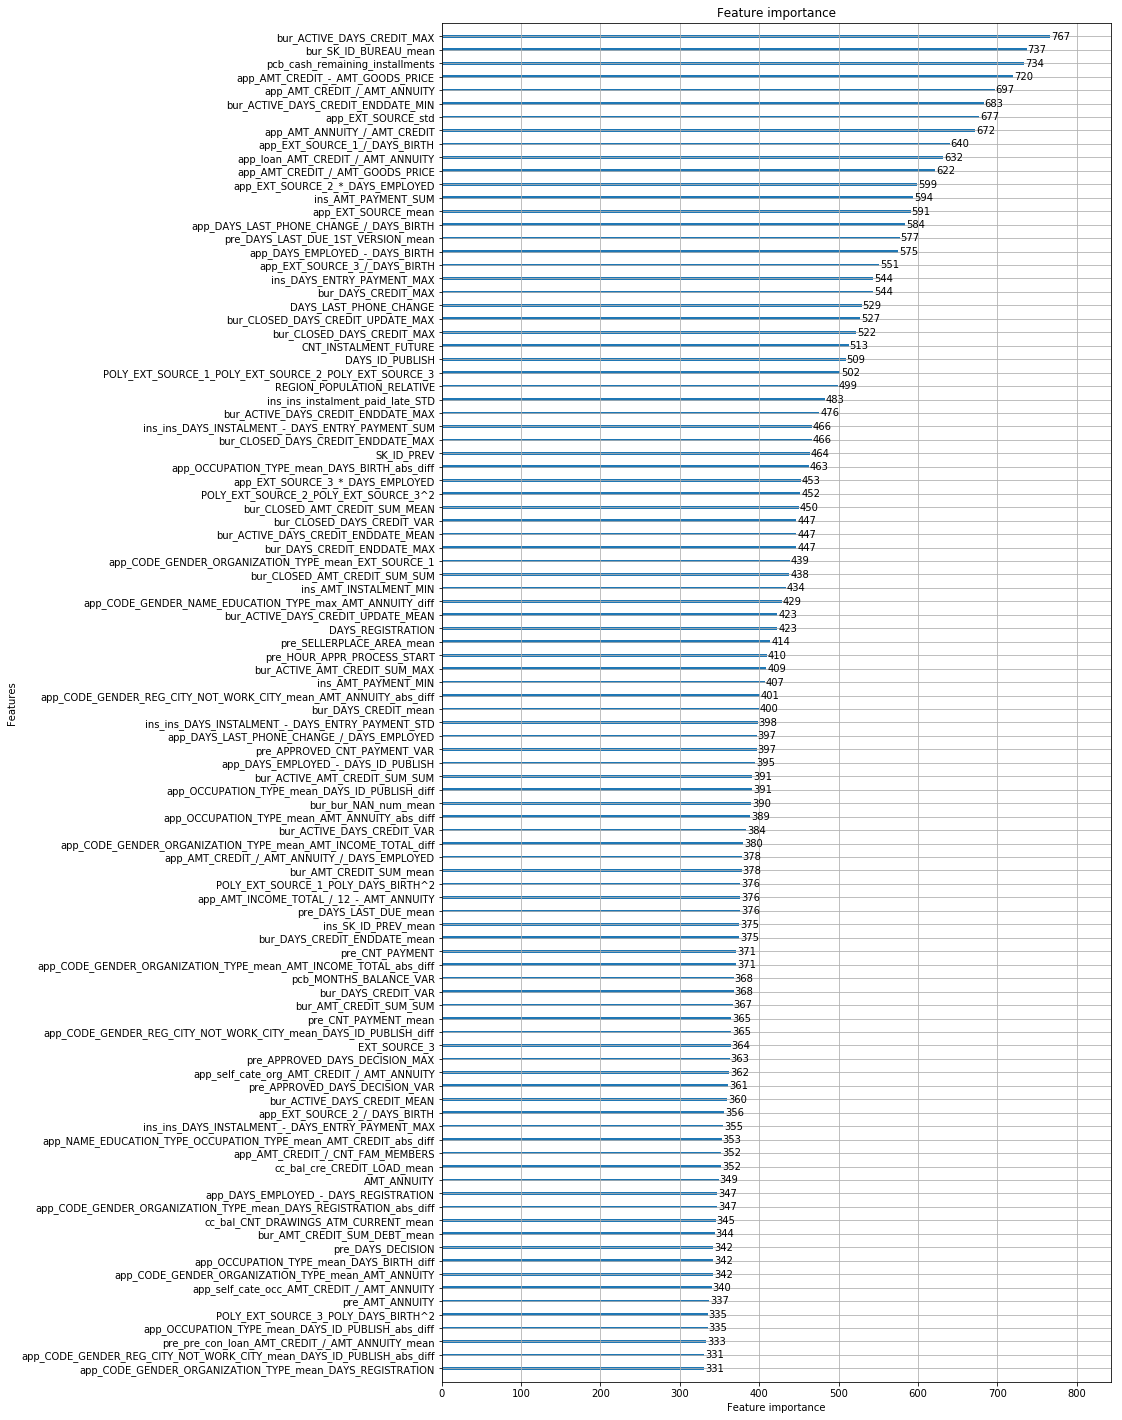

In [40]:
lgb.plot_importance(clf, figsize=(12, 25), max_num_features=100);


### <a id="5.1">5.1 Predict</a>

In [41]:
preds = np.mean(list_preds, axis=0)

#preds = None

    
sub_lgb = pd.DataFrame()
sub_lgb['SK_ID_CURR'] = test_id
sub_lgb['TARGET'] = preds
sub_lgb.to_csv("../output/16_all_5kfold.csv", index=False)
sub_lgb.head()

,SK_ID_CURR,TARGET
0,100001,0.044545
1,100005,0.127174
2,100013,0.012487
3,100028,0.036891
4,100038,0.118484


In [42]:
print('16 plus features')
print(sc_auc_score, ',' ,max_score)

16 plus features
0.7929070667893783 , 0.7962524269814413


In [43]:
print('result: ???')

result: ???


In [44]:
#16 plus features 3Kflold
#0.7911590072351249 , 0.7925018406854518
# 

In [45]:
#16 plus features 5K
#0.7929070667893783 , 0.7962524269814413


In [46]:
feature_importances_list = []
# 特徴量の表示
for i in range(1, data.shape[1]):
    feature_importances_list.append([data.columns[i], clf.feature_importances_[i-1]])

In [47]:
pd_importancs = pd.DataFrame(feature_importances_list)
pd_importancs.columns = ['features', 'score']
pd_importancs.sort_values('score', ascending=False)
pd_importancs.to_csv('../output/feature_importances_16_5kfold.csv', index=False)